The goal of this notebook is to determine the best time-decay weighting for past performance for IS1. The evaluation metric is overall correlation across puzzle days between performance over the previous ten matches at different time decay weightings, and the performance in the next match.

## Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
warnings.filterwarnings('ignore')
#print(sns.__version__)

## Load Data

Note: Data obtained from various sources (via scraping with Beautiful Soup, manual entry) and compiled into .xlsx format prior to this workstream

In [2]:
#Read file into a DataFrame and print head.
xword_data = pd.ExcelFile('../data/NYT_XWord_data.xlsx', engine='openpyxl')
print(xword_data.sheet_names)

['Sheet1']


In [3]:
df1 = xword_data.parse('Sheet1')

In [4]:
df1.head(35)

Puzzle_Date Completed_Date (IS1) Completed_Date (IS2) Day_of_Week  \
0   2024-01-25  2024-01-25 07:17:58                  NaT    Thursday   
1   2024-01-24  2024-01-24 06:48:01  2024-01-24 18:11:25   Wednesday   
2   2024-01-23  2024-01-23 06:53:25  2024-01-23 14:05:58     Tuesday   
3   2024-01-22  2024-01-22 08:09:11  2024-01-21 18:26:08      Monday   
4   2024-01-21  2024-01-21 08:41:27  2024-01-20 19:02:30      Sunday   
5   2024-01-20  2024-01-20 07:24:53  2024-01-20 10:45:59    Saturday   
6   2024-01-19  2024-01-19 08:50:38  2024-01-19 12:55:34      Friday   
7   2024-01-18  2024-01-18 08:23:39  2024-01-18 15:44:37    Thursday   
8   2024-01-17  2024-01-17 08:01:57  2024-01-17 17:56:31   Wednesday   
9   2024-01-16  2024-01-16 07:25:58  2024-01-16 12:42:56     Tuesday   
10  2024-01-15  2024-01-15 07:41:52  2024-01-14 21:22:47      Monday   
11  2024-01-14  2024-01-14 08:36:14  2024-01-13 20:53:10      Sunday   
12  2024-01-13  2024-01-13 07:00:29  2024-01-13 20:00:39    Saturday   
13  2024-01-12  2024-01-12 07:14:59  2024-01-12 14:55:45      Friday   
14  2024-01-11  2024-01-11 07:15:39  2024-01-11 19:04:26    Thursday   
15  2024-01-10  2024-01-10 06:50:06  2024-01-10 18:33:40   Wednesday   
16  2024-01-09  2024-01-09 07:28:21  2024-01-09 09:34:24     Tuesday   
17  2024-01-08  2024-01-07 20:18:53  2024-01-07 20:01:13      Monday   
18  2024-01-07  2024-01-07 06:20:29  2024-01-06 22:49:00      Sunday   
19  2024-01-06  2024-01-06 07:56:40  2024-01-06 18:56:20    Saturday   
20  2024-01-05  2024-01-05 07:24:33  2024-01-05 17:36:03      Friday   
21  2024-01-04  2024-01-04 07:06:17  2024-01-04 16:09:11    Thursday   
22  2024-01-03  2024-01-03 07:57:47  2024-01-03 21:00:36   Wednesday   
23  2024-01-02  2024-01-02 07:24:01  2024-01-02 09:10:42     Tuesday   
24  2024-01-01  2024-01-01 08:21:39  2024-01-01 15:08:40      Monday   
25  2023-12-31  2023-12-30 18:57:40  2023-12-30 19:51:36      Sunday   
26  2023-12-30  2023-12-30 07:14:48  2023-12-30 10:16:35    Saturday   
27  2023-12-29  2023-12-29 08:42:13  2023-12-28 22:29:38      Friday   
28  2023-12-28  2023-12-28 08:21:40  2023-12-28 11:26:38    Thursday   
29  2023-12-27  2023-12-27 09:02:32  2023-12-27 10:46:57   Wednesday   
30  2023-12-26  2023-12-26 08:15:55  2023-12-26 10:52:11     Tuesday   
31  2023-12-25  2023-12-25 08:22:02  2023-12-25 10:23:57      Monday   
32  2023-12-24  2023-12-23 18:37:23  2023-12-23 23:27:09      Sunday   
33  2023-12-23  2023-12-23 07:36:04  2023-12-23 18:53:42    Saturday   
34  2023-12-22  2023-12-22 08:00:02  2023-12-22 08:08:59      Friday   

    Time (s) (IS1)  Time (s) (IS2)  Global_Median_Solver_Time(s) Difficulty  \
0            808.0             NaN                          1005       Hard   
1            313.0           582.0                           541  Very Easy   
2            259.0           376.0                           380       Easy   
3            348.0           428.0                           376       Hard   
4           1088.0          1073.0                          1519    Average   
5            772.0          1484.0                          1210    Average   
6            723.0           883.0                           997    Average   
7           1045.0          1219.0                          1131       Hard   
8            435.0           619.0                           688    Average   
9            335.0           408.0                           525       Hard   
10           293.0           380.0                           367       Hard   
11          1224.0          1330.0                          1975       Hard   
12           459.0           559.0                           796  Very Easy   
13           556.0           965.0                          1036    Average   
14           549.0           998.0                           904    Average   
15           526.0           646.0                           878       Hard   
16           286.0           350.0                           474   

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Puzzle_Date                   2216 non-null   datetime64[ns]
 1   Completed_Date (IS1)          1172 non-null   datetime64[ns]
 2   Completed_Date (IS2)          1063 non-null   datetime64[ns]
 3   Day_of_Week                   2216 non-null   object        
 4   Time (s) (IS1)                1172 non-null   float64       
 5   Time (s) (IS2)                1063 non-null   float64       
 6   Global_Median_Solver_Time(s)  2216 non-null   int64         
 7   Difficulty                    2216 non-null   object        
 8   Median_Solver%_AVG_PM         2216 non-null   int64         
 9   Grid Size                     2216 non-null   int64         
 10  No_Constructors               2216 non-null   int64         
 11  Constructors(by seniority)    

## Data Cleaning and Global Median Solver Feature Creation
A few generally useful operations for the exploratory analysis of Individual Solver 1 (IS1)

In [ ]:
# Delete weird columns at the back end of the imported data
#df2 = df1.drop(columns=df1.columns[-6:], axis=1)

In [6]:
# Drop Some columns that, while potentially useful for predictive modeling, aren't necessary for the EDA.
df2 = df1.drop(['Difficulty', '1st_Constructor', '1st_Constuctor_Gender', '1st_Constructor_Puzzle_N', '1st_Constructor_Debut', '1st_Constructor_Scrabble_Avg', '1st_Constructor_Fresh%_Avg', '2nd_Constructor', '2nd_Constuctor_Gender', '2nd_Constructor_Puzzle_N', '2nd_Constructor_Debut', '2nd_Constructor_Scrabble_Avg', '2nd_Constructor_Fresh%_Avg', '3rd_Constructor', '3rd_Constuctor_Gender', '3rd_Constructor_Puzzle_N', '3rd_Constructor_Debut', '3rd_Constructor_Scrabble_Avg', '3rd_Constructor_Fresh%_Avg', 'Spans', '2_Stacks', '3_4_Stacks', 'Mirror_Sym', 'UD_Sym', 'Asym', 'Supersym', '90_180_Rot_Sym', 'LR_UD_Sym', 'Diag_Sym', 'Black_Square_Fill','Outside_Grid', 'Unchecked_Sq','Uniclue','Duplicate_Answers','Quantum'], axis=1)

In [7]:
# Rename some columns for brevity and clarity
df2.rename(columns={'Constructors(by seniority)': 'Constructors', 'Median_Solver%_AVG_PM':'Diff%_from_10pMA(GMS)', 'Day_of_Week': 'DOW', 'Puzzle_Date': 'P_Date', 'Median_Solver%_AVG_PM': 'GMST_Diff%_from_GMS_10p_MA'}, inplace=True)

In [8]:
# It will be useful generally to have puzzle dates as strings in other columns along with the datetimes 
df2['P_Date_str'] = df2['P_Date'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [9]:
# Convert global median solve times (GMTs) per puzzle to minutes and drop times in seconds
df2["GMST(m)"] = df2["Global_Median_Solver_Time(s)"]/60  #GMST = Global Median solve times
df2.drop(['Global_Median_Solver_Time(s)'], axis=1, inplace=True)

In [10]:
#GMS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the GMS over the previous 10 puzzles
# Note that the sort is by puzzle issue date for the GMS, as completion date is not avaiable (sequence is assumed to be that of issue date)
# Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

df2 = df2.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

df2["GMS_pds_l10_dw_1"] = df2.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df2["GMS_pds_l10_dw_2"] = df2.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df2["GMS_pds_l10_dw_3"] = df2.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df2["GMS_pds_l10_dw_4"] = df2.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df2["GMS_pds_l10_dw_5"] = df2.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df2["GMS_pds_l10_dw_6"] = df2.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df2["GMS_pds_l10_dw_7"] = df2.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df2["GMS_pds_l10_dw_8"] = df2.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df2["GMS_pds_l10_dw_9"] = df2.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df2["GMS_pds_l10_dw_10"] = df2.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

df2["GMS_pds_l10_dw_1_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-1)/df2.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df2["GMS_pds_l10_dw_2_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-2)/df2.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df2["GMS_pds_l10_dw_3_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-3)/df2.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df2["GMS_pds_l10_dw_4_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-4)/df2.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df2["GMS_pds_l10_dw_5_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-5)/df2.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df2["GMS_pds_l10_dw_6_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-6)/df2.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df2["GMS_pds_l10_dw_7_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-7)/df2.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df2["GMS_pds_l10_dw_8_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-8)/df2.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df2["GMS_pds_l10_dw_9_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-9)/df2.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df2["GMS_pds_l10_dw_10_ct"] = (df2.groupby(['DOW'])['GMST(m)'].shift(-10)/df2.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

df2["GMS_pds_l10_ws"] = df2[["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10"]].sum(axis=1)
df2["GMS_pds_l10_ws_ct"] = df2[["GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct"]].sum(axis=1)
df2["GMS_pds_l10_dw"] = df2["GMS_pds_l10_ws"]/df2["GMS_pds_l10_ws_ct"]

# Deleting transient columns
df2 = df2.drop(["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10", "GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct", "GMS_pds_l10_ws", "GMS_pds_l10_ws_ct"], axis = 1)

In [11]:
# Calculate 10-puzzle moving average for global median solver (GMS) raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do NOT have completion dates for median solver per puzzle. It is therefore assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['DOW','P_Date'], ascending = True)
df2['GMST(m)_10p_MA'] = df2.groupby('DOW')['GMST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['DOW','P_Date'], ascending = False)

In [12]:
# Calculate deviation from GMS_pds_l10_dw for GMS
df2['GMST_Diff%_from_GMS_pds_l10_dw'] = (((df2['GMST(m)'] - df2['GMS_pds_l10_dw']))/((df2['GMST(m)'] + df2['GMS_pds_l10_dw'])/2)*100).round(2)

df2 = df2.sort_values(by=['DOW','P_Date'], ascending = False)

In [13]:
# It will be useful to have year of puzzle issue in a separate column for analysis below
df2['P_Yr'] = df2['P_Date'].dt.to_period('Y')
df2['P_Yr'].value_counts()

2020    366
2023    365
2021    365
2019    365
2022    365
2018    365
2024     25
Freq: A-DEC, Name: P_Yr, dtype: int64

In [14]:
# Also, a column indicating pre-2023 puzzle issue date or 2023-2024 puzzle issue date
df2.loc[(df2["P_Yr"] != "2023") & (df2["P_Yr"] != "2024"), "2023+_puzzle"] = 0 #pre-2023 puzzle issue date
df2.loc[(df2["P_Yr"] == "2023") | (df2["P_Yr"] == "2024"), "2023+_puzzle"] = 1 #2023 or 2024 puzzle issue date
df2['2023+_puzzle'].value_counts()

0.0    1826
1.0     390
Name: 2023+_puzzle, dtype: int64

In [15]:
# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df2.loc[(df2["DOW"] == "Sunday"), "DOW_num"] = 1 
df2.loc[(df2["DOW"] == "Monday"), "DOW_num"] = 2
df2.loc[(df2["DOW"] == "Tuesday"), "DOW_num"] = 3
df2.loc[(df2["DOW"] == "Wednesday"), "DOW_num"] = 4
df2.loc[(df2["DOW"] == "Thursday"), "DOW_num"] = 5
df2.loc[(df2["DOW"] == "Friday"), "DOW_num"] = 6
df2.loc[(df2["DOW"] == "Saturday"), "DOW_num"] = 7

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 1 to 2211
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          2216 non-null   datetime64[ns]
 1   Completed_Date (IS1)            1172 non-null   datetime64[ns]
 2   Completed_Date (IS2)            1063 non-null   datetime64[ns]
 3   DOW                             2216 non-null   object        
 4   Time (s) (IS1)                  1172 non-null   float64       
 5   Time (s) (IS2)                  1063 non-null   float64       
 6   GMST_Diff%_from_GMS_10p_MA      2216 non-null   int64         
 7   Grid Size                       2216 non-null   int64         
 8   No_Constructors                 2216 non-null   int64         
 9   Constructors                    2216 non-null   object        
 10  Words                           2216 non-null   int64         
 11  Bloc

In [17]:
# Move new columns to logical places in dataframe
col = df2.pop('P_Date_str')
df2.insert(1, col.name, col)

col = df2.pop('P_Yr')
df2.insert(2, col.name, col)

col = df2.pop('2023+_puzzle')
df2.insert(3, col.name, col)

col = df2.pop('DOW')
df2.insert(4, col.name, col)

col = df2.pop('DOW_num')
df2.insert(5, col.name, col)

col = df2.pop('GMST(m)')
df2.insert(6, col.name, col)

col = df2.pop('GMST(m)_10p_MA')
df2.insert(7, col.name, col)

col = df2.pop('GMST_Diff%_from_GMS_10p_MA')
df2.insert(8, col.name, col)

col = df2.pop('GMS_pds_l10_dw')
df2.insert(9, col.name, col)

col = df2.pop('GMST_Diff%_from_GMS_pds_l10_dw')
df2.insert(10, col.name, col)

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 1 to 2211
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          2216 non-null   datetime64[ns]
 1   P_Date_str                      2216 non-null   object        
 2   P_Yr                            2216 non-null   period[A-DEC] 
 3   2023+_puzzle                    2216 non-null   float64       
 4   DOW                             2216 non-null   object        
 5   DOW_num                         2216 non-null   float64       
 6   GMST(m)                         2216 non-null   float64       
 7   GMST(m)_10p_MA                  2202 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      2216 non-null   int64         
 9   GMS_pds_l10_dw                  2209 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  2209 non-null   float64       
 11  Comp

In [19]:
# Checkpoint
df2.to_csv('../data/df2.csv', index=False)

## Individual Solver 1 (IS1) Data Cleaning and Feature Creation

In [19]:
# Keep only puzzles for which IS1 has a solve time, and drop columns specific to Individual Solver 2 (IS2)
df_IS1 = df2.dropna(subset=['Time (s) (IS1)'])
df_IS1.drop(["Completed_Date (IS2)", "Time (s) (IS2)"], axis = 1, inplace=True)

In [20]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1 to 1168
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          1172 non-null   datetime64[ns]
 1   P_Date_str                      1172 non-null   object        
 2   P_Yr                            1172 non-null   period[A-DEC] 
 3   2023+_puzzle                    1172 non-null   float64       
 4   DOW                             1172 non-null   object        
 5   DOW_num                         1172 non-null   float64       
 6   GMST(m)                         1172 non-null   float64       
 7   GMST(m)_10p_MA                  1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      1172 non-null   int64         
 9   GMS_pds_l10_dw                  1172 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  1172 non-null   float64       
 11  Comp

In [21]:
df_IS1.head()

P_Date  P_Date_str  P_Yr  2023+_puzzle        DOW  DOW_num    GMST(m)  \
1  2024-01-24  2024-01-24  2024           1.0  Wednesday      4.0   9.016667   
8  2024-01-17  2024-01-17  2024           1.0  Wednesday      4.0  11.466667   
15 2024-01-10  2024-01-10  2024           1.0  Wednesday      4.0  14.633333   
22 2024-01-03  2024-01-03  2024           1.0  Wednesday      4.0  10.233333   
29 2023-12-27  2023-12-27  2023           1.0  Wednesday      4.0  13.683333   

    GMST(m)_10p_MA  GMST_Diff%_from_GMS_10p_MA  GMS_pds_l10_dw  ...  \
1        11.356667                         -30       12.128182  ...   
8        11.953333                         -13       12.233333  ...   
15       12.045000                          12       11.785758  ...   
22       12.171667                         -23       12.195758  ...   
29       12.488333                           5       11.915758  ...   

    Scrabble_Illegal Open_Squares  Freshness_Factor  Overall_Freshness%  \
1                 25           85              22.4                 8.5   
8                 34           72              34.9                47.6   
15                31           65              27.0                21.2   
22                25           56              27.5                22.6   
29                30           73              39.7                62.9   

    Day_Freshness% Duplicate_Clues  Circle_Count  Shade_Count  Unusual_Sym  \
1              9.6               0             0            0            0   
8             76.2               0             0            0            0   
15            31.5               0             0            0            0   
22            33.9               1             0            0            0   
29            91.0               0             0           22            0   

    Wordplay  
1        7.0  
8        3.0  
15       8.0  
22       5.0  
29       6.0  

[5 rows x 39 columns]

In [22]:
# It will be useful to have IS1 puzzle completion dates as strings in other columns along with the datetimes 
df_IS1['Comp_Date_str'] = df_IS1['Completed_Date (IS1)'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [23]:
# Convert Individual Solver1 (IS1) solve times per puzzle to minutes and drop times in seconds
df_IS1["IST(m)"] = df_IS1["Time (s) (IS1)"]/60   #IST = Individual solver times 
df_IS1.drop(['Time (s) (IS1)'], axis=1, inplace=True)

In [24]:
# It will be useful to have year of puzzle completion for this solver in a separate column for analysis below
df_IS1['Comp_Yr'] = df_IS1['Completed_Date (IS1)'].dt.to_period('Y')
df_IS1['Comp_Yr'].value_counts()

2022    493
2023    424
2021    230
2024     25
Freq: A-DEC, Name: Comp_Yr, dtype: int64

In [25]:
# Also, a column indicating pre-2023 solve or 2023/204 solve
df_IS1.loc[(df_IS1["Comp_Yr"] == "2023") | (df_IS1["Comp_Yr"] == "2024"), "2023+_solve"] = 1 #2023_2024 solve
df_IS1.loc[(df_IS1["Comp_Yr"] != "2023") & (df_IS1["Comp_Yr"] != "2024"), "2023+_solve"] = 0 #pre-2023 solve
df_IS1['2023+_solve'].value_counts()

0.0    723
1.0    449
Name: 2023+_solve, dtype: int64

In [26]:
# Rename a column for brevity and clarity
df_IS1.rename(columns={'Completed_Date (IS1)': 'Comp_Date'}, inplace=True)

In [27]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1 to 1168
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          1172 non-null   datetime64[ns]
 1   P_Date_str                      1172 non-null   object        
 2   P_Yr                            1172 non-null   period[A-DEC] 
 3   2023+_puzzle                    1172 non-null   float64       
 4   DOW                             1172 non-null   object        
 5   DOW_num                         1172 non-null   float64       
 6   GMST(m)                         1172 non-null   float64       
 7   GMST(m)_10p_MA                  1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      1172 non-null   int64         
 9   GMS_pds_l10_dw                  1172 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  1172 non-null   float64       
 11  Comp

In [28]:
# Move new columns to logical places in dataframe
col = df_IS1.pop('Comp_Date_str')
df_IS1.insert(12, col.name, col)

col = df_IS1.pop('Comp_Yr')
df_IS1.insert(13, col.name, col)

col = df_IS1.pop('2023+_solve')
df_IS1.insert(14, col.name, col)

col = df_IS1.pop('IST(m)')
df_IS1.insert(15, col.name, col)

In [29]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1 to 1168
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          1172 non-null   datetime64[ns]
 1   P_Date_str                      1172 non-null   object        
 2   P_Yr                            1172 non-null   period[A-DEC] 
 3   2023+_puzzle                    1172 non-null   float64       
 4   DOW                             1172 non-null   object        
 5   DOW_num                         1172 non-null   float64       
 6   GMST(m)                         1172 non-null   float64       
 7   GMST(m)_10p_MA                  1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      1172 non-null   int64         
 9   GMS_pds_l10_dw                  1172 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  1172 non-null   float64       
 11  Comp

## Feature Calculations

In [30]:
# Calculate 10-puzzle moving average for individual solver (IS1) raw solve times, per Day of Week
#Unlike for GMS, we DO have completion dates for individual solver per puzzle. Therefore we use completion date, not puzzle date
df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS1['IST(m)_10p_MA'] = df_IS1.groupby('DOW')['IST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [31]:
#IS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the individual solver (IS1) over the previous 10 puzzles
# Note that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

df_IS1 = df_IS1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

df_IS1["IS_pds_l10_dw_1"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
df_IS1["IS_pds_l10_dw_2"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
df_IS1["IS_pds_l10_dw_3"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
df_IS1["IS_pds_l10_dw_4"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
df_IS1["IS_pds_l10_dw_5"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
df_IS1["IS_pds_l10_dw_6"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
df_IS1["IS_pds_l10_dw_7"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
df_IS1["IS_pds_l10_dw_8"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
df_IS1["IS_pds_l10_dw_9"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
df_IS1["IS_pds_l10_dw_10"] = df_IS1.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]

df_IS1["IS_pds_l10_dw_1_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-1)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
df_IS1["IS_pds_l10_dw_2_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-2)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
df_IS1["IS_pds_l10_dw_3_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-3)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
df_IS1["IS_pds_l10_dw_4_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-4)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
df_IS1["IS_pds_l10_dw_5_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-5)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
df_IS1["IS_pds_l10_dw_6_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-6)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
df_IS1["IS_pds_l10_dw_7_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-7)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
df_IS1["IS_pds_l10_dw_8_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-8)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
df_IS1["IS_pds_l10_dw_9_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-9)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
df_IS1["IS_pds_l10_dw_10_ct"] = (df_IS1.groupby(['DOW'])['IST(m)'].shift(-10)/df_IS1.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]

df_IS1["IS_pds_l10_ws"] = df_IS1[["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10"]].sum(axis=1)
df_IS1["IS_pds_l10_ws_ct"] = df_IS1[["IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct"]].sum(axis=1)
df_IS1["IS_pds_l10_dw"] = df_IS1["IS_pds_l10_ws"]/df_IS1["IS_pds_l10_ws_ct"]

# Deleting transient columns
df_IS1 = df_IS1.drop(["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10", "IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis = 1)

In [32]:
# Calculate deviation from puzzle day-specific recent solve form (IS_pds_l10_dw) per individual raw solve time for individual solver (IS1)
df_IS1['IST_Diff%_from_IS_pds_l10_dw'] = (((df_IS1['IST(m)'] - df_IS1['IS_pds_l10_dw']))/((df_IS1['IST(m)'] + df_IS1['IS_pds_l10_dw'])/2)*100).round(2)

df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [33]:
# Calculate solve time % difference for IST from Global Median Solve Time, per solve
# Used for Supplemental Figure 1
df_IS1['IST_Diff%_from_GMST'] = (((df_IS1['IST(m)'] - df_IS1['GMST(m)']))/((df_IS1['IST(m)'] + df_IS1['GMST(m)'])/2)*100).round(2)

# Now compute 10-puzzle moving average for this difference from global median solver
df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS1['10pMA_of_IST_Diff%_from_GMST'] = df_IS1.groupby('DOW')['IST_Diff%_from_GMST'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))

df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [34]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1 to 895
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          1172 non-null   datetime64[ns]
 1   P_Date_str                      1172 non-null   object        
 2   P_Yr                            1172 non-null   period[A-DEC] 
 3   2023+_puzzle                    1172 non-null   float64       
 4   DOW                             1172 non-null   object        
 5   DOW_num                         1172 non-null   float64       
 6   GMST(m)                         1172 non-null   float64       
 7   GMST(m)_10p_MA                  1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      1172 non-null   int64         
 9   GMS_pds_l10_dw                  1172 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  1172 non-null   float64       
 11  Comp_

In [35]:
# Move new columns to logical places in dataframe
col = df_IS1.pop('IST(m)_10p_MA')
df_IS1.insert(16, col.name, col)

col = df_IS1.pop('IS_pds_l10_dw')
df_IS1.insert(17, col.name, col)

col = df_IS1.pop('IST_Diff%_from_IS_pds_l10_dw')
df_IS1.insert(18, col.name, col)

col = df_IS1.pop('IST_Diff%_from_GMST')
df_IS1.insert(19, col.name, col)

col = df_IS1.pop('10pMA_of_IST_Diff%_from_GMST')
df_IS1.insert(20, col.name, col)

In [36]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1 to 895
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          1172 non-null   datetime64[ns]
 1   P_Date_str                      1172 non-null   object        
 2   P_Yr                            1172 non-null   period[A-DEC] 
 3   2023+_puzzle                    1172 non-null   float64       
 4   DOW                             1172 non-null   object        
 5   DOW_num                         1172 non-null   float64       
 6   GMST(m)                         1172 non-null   float64       
 7   GMST(m)_10p_MA                  1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      1172 non-null   int64         
 9   GMS_pds_l10_dw                  1172 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  1172 non-null   float64       
 11  Comp_

In [38]:
# Checkpoint
df_IS1.to_csv('../data/df_IS1.csv', index=False)

#### Overview Statistics for IS1

In [37]:
# Compute total solve time for IS1, and solve time per solve period
print(df_IS1["IST(m)"].sum())
print(df_IS1.loc[df_IS1["Comp_Yr"]==("2021"), "IST(m)"].sum())
print(df_IS1.loc[df_IS1["Comp_Yr"]==("2022"), "IST(m)"].sum())
print(df_IS1.loc[(df_IS1["Comp_Yr"]==("2023")) | (df_IS1["Comp_Yr"]==("2024")), "IST(m)"].sum())

15478.316666666666
3162.5833333333335
6685.4
5630.333333333334


In [38]:
# Compute total solve time for GMS over the set of puzzles solved by IS1
print(df_IS1["GMST(m)"].sum())

21166.366666666665


In [41]:
# Checkpoint
df_IS1.to_csv('../data/df_IS1.csv', index=False)

## Individual Solver 1 (IS1) Figure Creation

#### IS1 Solve Performance Over Time

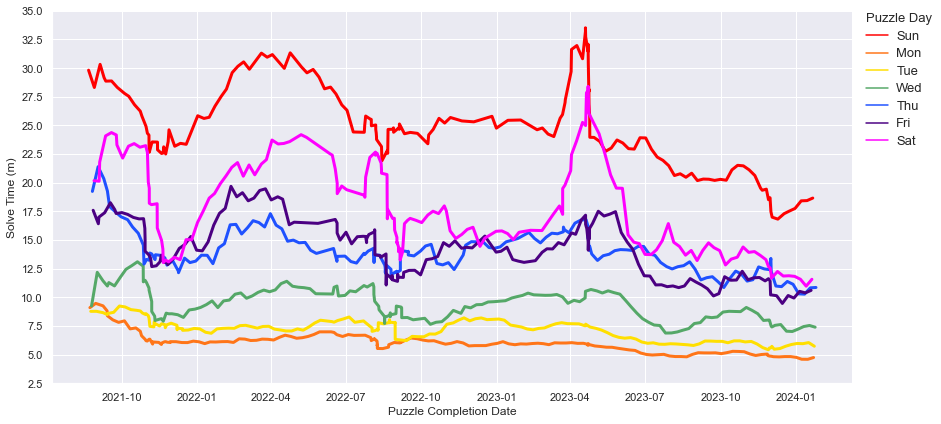

In [39]:
# Plot 10-puzzle moving average of IS1 Solve Times by Day of Week
#Figure2

sns.set(font_scale=1)

p = sns.relplot(
    data=df_IS1, marker = "", x="Comp_Date", y="IST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Completion Date", yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.89, .975])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

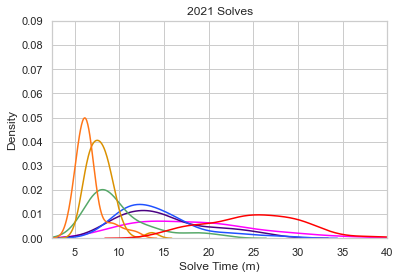

In [40]:
# Density Plot for 2021 Only 
# Figure 2
df1_2021 = df_IS1.loc[(df_IS1["Comp_Yr"] == "2021")]

df1_2021['plot_seq_map'] = df1_2021['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df1_2021, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 40)
plt.ylim(0, .09)
plt.xticks([5,10,15,20,25,30,35,40])
plt.title('2021 Solves')
ax.set_xlabel("Solve Time (m)")
plt.show()

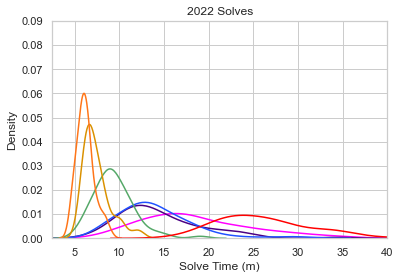

In [41]:
# Density Plot for 2022 Only 
# Figure 2
df1_2022 = df_IS1.loc[(df_IS1["Comp_Yr"] == "2022")]

df1_2022['plot_seq_map'] = df1_2022['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df1_2022, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 40)
plt.ylim(0, .09)
plt.xticks([5,10,15,20,25,30,35,40])
plt.title('2022 Solves')
ax.set_xlabel("Solve Time (m)")
plt.show()

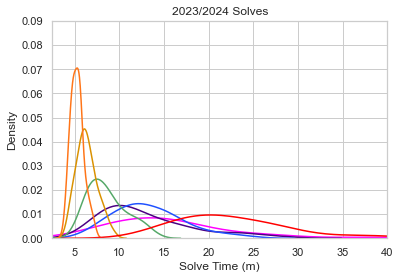

In [42]:
# Density Plot for 2023-2024 Only 
# Figure 2
df1_2023 = df_IS1.loc[(df_IS1["Comp_Yr"] == "2023") | (df_IS1["Comp_Yr"] == "2024")]

df1_2023['plot_seq_map'] = df1_2023['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df1_2023, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 40)
plt.ylim(0, .09)
plt.xticks([5,10,15,20,25,30,35,40])
plt.title('2023/2024 Solves')
ax.set_xlabel("Solve Time (m)")
plt.show()

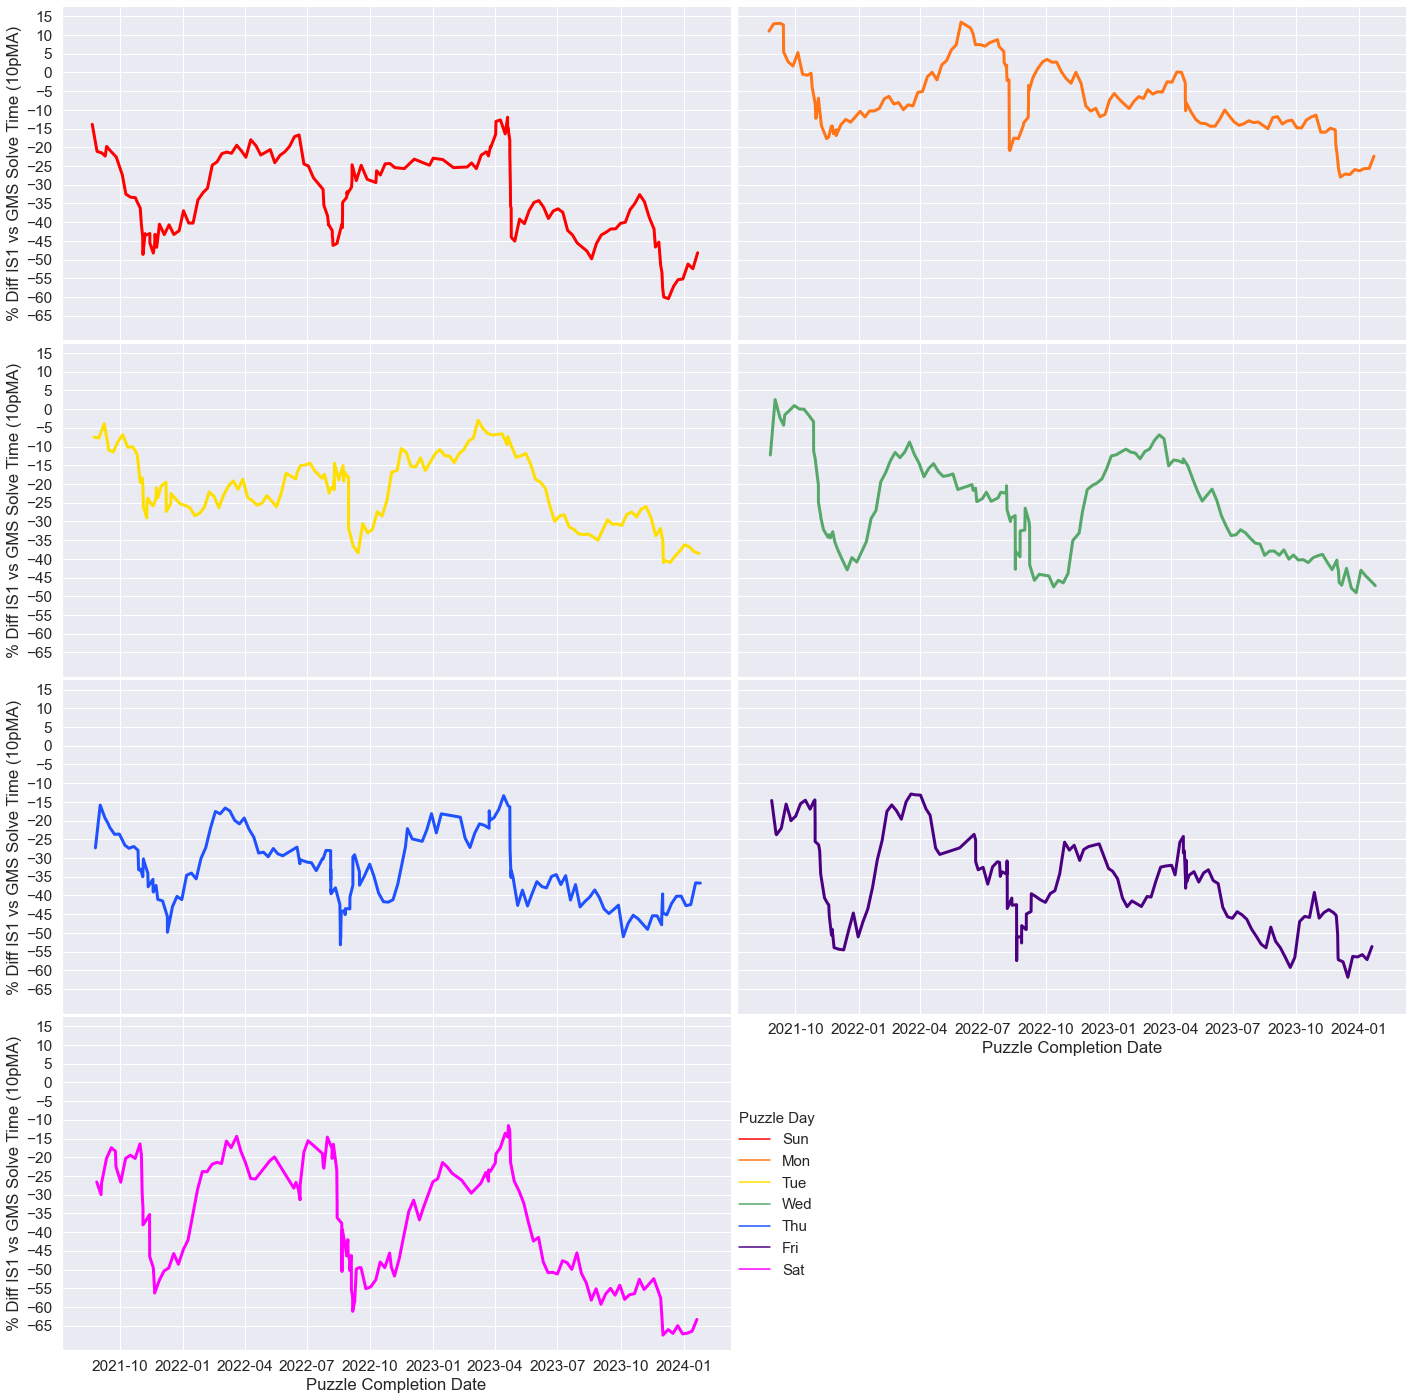

In [43]:
# Plot 10-puzzle moving average of % Difference in Individual Solve Times From Global Median Solve Times
# This normalizes for puzzle difficulty
# Supplmentary Figure 1

sns.set(font_scale=1.4)
#sns.set(rc={'axes.facecolor':'gray',"axes.grid":True,'xtick.labelsize':14,'ytick.labelsize':14})

p = sns.relplot(
    data=df_IS1, marker = "", x="Comp_Date", y="10pMA_of_IST_Diff%_from_GMST", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=5, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3, col="DOW", col_wrap=2, col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"]
).set(title="", ylabel="% Diff IS1 vs GMS Solve Time (10pMA)",
    xlabel= "Puzzle Completion Date", yticks = [-65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
)

plt.subplots_adjust(wspace = 0.01) #decrease whitespace btwn subplot colums
plt.subplots_adjust(hspace = 0.01) #decrease whitespace btwn subplot rows

# # # Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.46, .21])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(15)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(15)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(15)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(15)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(15)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(15)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(15)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(15)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

#title="10-Puzzle Moving Average of % Difference in Solve Times From Global Median Solve Times (Solver 1)", 

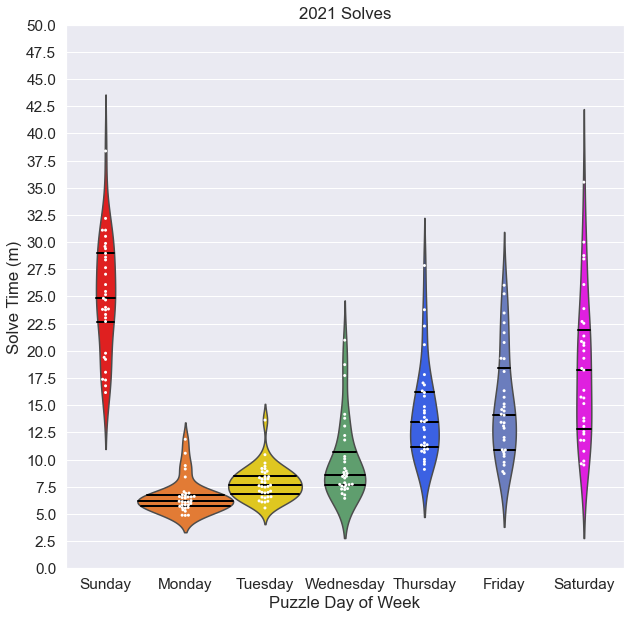

In [44]:
# Violin plots with swarm plot overlay by puzzle day 2021 solves only
# Figure 3

IS1_pre2022 = df_IS1.loc[df_IS1["Comp_Date_str"].str.contains("2021")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_pre2022 , size=3.0 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_pre2022['DOW'], IS1_pre2022['IST(m)'], width = 1.2, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 50)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2021 Solves")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [45]:
# Calculate Median and IQR per puzzle day, for 2021 solves
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    33.0
mean     25.1
std       5.2
min      16.2
25%      22.7
50%      24.8
75%      29.0
max      38.4
Name: IST(m), dtype: float64
count    34.0
mean      6.6
std       1.6
min       4.9
25%       5.7
50%       6.2
75%       6.7
max      11.9
Name: IST(m), dtype: float64
count    36.0
mean      7.9
std       1.5
min       5.6
25%       6.8
50%       7.6
75%       8.5
max      13.6
Name: IST(m), dtype: float64
count    32.0
mean      9.9
std       3.7
min       6.4
25%       7.6
50%       8.5
75%      10.7
max      21.0
Name: IST(m), dtype: float64
count    32.0
mean     14.3
std       4.4
min       9.1
25%      11.2
50%      13.5
75%      16.2
max      27.8
Name: IST(m), dtype: float64
count    32.0
mean     15.1
std       4.9
min       8.7
25%      10.9
50%      14.1
75%      18.4
max      26.0
Name: IST(m), dtype: float64
count    31.0
mean     18.4
std       6.7
min       9.5
25%      12.8
50%      18.2
75%      22.0
max      35.5
Name: IST(m), dtype: float64


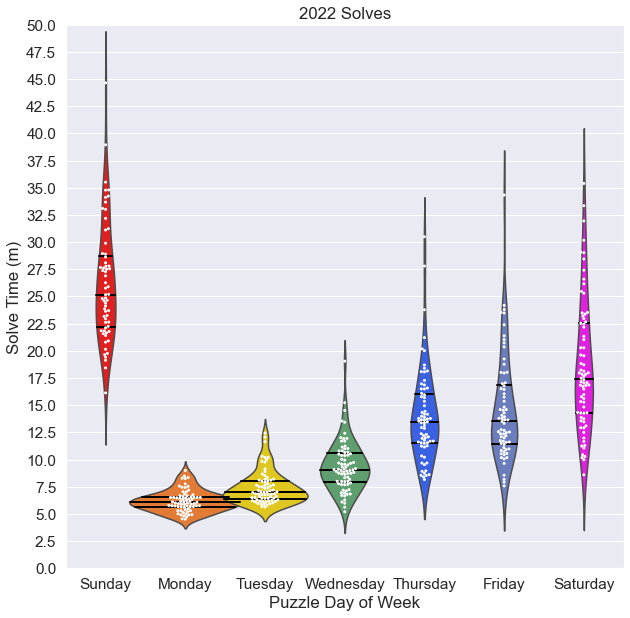

In [46]:
# Violin plots with swarm plot overlay by puzzle day -2022 solves only
#Figure 3

IS1_2022 = df_IS1.loc[df_IS1["Comp_Date_str"].str.contains("2022")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_2022 , size=3.0 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_2022['DOW'], IS1_2022['IST(m)'], width = 1.4, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 50)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2022 Solves")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [47]:
# Calculate Median and IQR per puzzle day, for 2022
print(IS1_2022.loc[(IS1_2022["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    63.0
mean     26.3
std       5.4
min      16.1
25%      22.2
50%      25.2
75%      28.8
max      44.6
Name: IST(m), dtype: float64
count    70.0
mean      6.2
std       1.0
min       4.5
25%       5.7
50%       6.1
75%       6.6
max       9.0
Name: IST(m), dtype: float64
count    72.0
mean      7.4
std       1.5
min       5.6
25%       6.4
50%       7.0
75%       8.1
max      12.4
Name: IST(m), dtype: float64
count    76.0
mean      9.4
std       2.3
min       5.2
25%       7.9
50%       9.1
75%      10.6
max      19.0
Name: IST(m), dtype: float64
count    70.0
mean     14.0
std       4.3
min       8.2
25%      11.5
50%      13.5
75%      16.1
max      30.5
Name: IST(m), dtype: float64
count    68.0
mean     14.6
std       4.8
min       7.6
25%      11.5
50%      13.6
75%      16.8
max      34.3
Name: IST(m), dtype: float64
count    74.0
mean     18.6
std       6.0
min       8.6
25%      14.3
50%      17.4
75%      22.5
max      35.4
Name: IST(m), dtype: float64


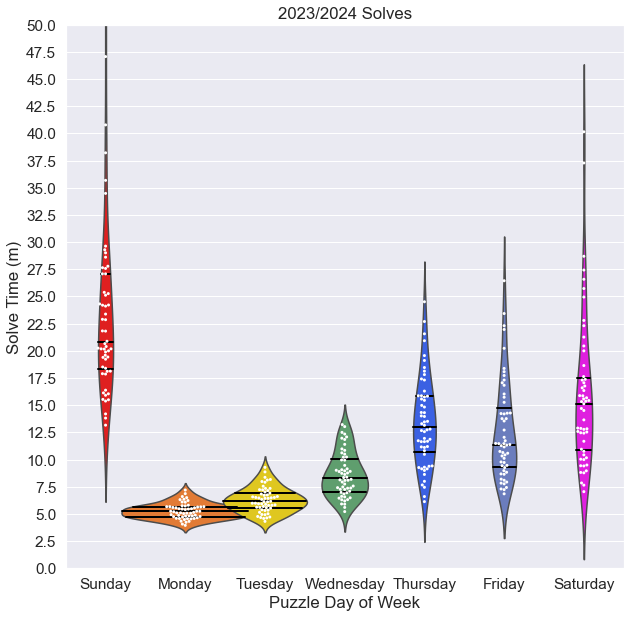

In [48]:
# Violin plots with swarm plot overlay by puzzle day -2023/4 only
# Figure 3

sns.set(font_scale=1.4)

IS1_2023 = df_IS1.loc[df_IS1["P_Date_str"].str.contains("2023") | df_IS1["P_Date_str"].str.contains("2024")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_2023 , size=3.0 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_2023['DOW'], IS1_2023['IST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 50)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2023/2024 Solves")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [49]:
# Calculate Median and IQR per puzzle day, for 2023/2024
print(IS1_2023.loc[(IS1_2023["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    56.0
mean     23.4
std       7.9
min      13.2
25%      18.3
50%      20.8
75%      27.1
max      52.2
Name: IST(m), dtype: float64
count    56.0
mean      5.3
std       0.7
min       4.0
25%       4.8
50%       5.2
75%       5.7
max       7.2
Name: IST(m), dtype: float64
count    56.0
mean      6.3
std       1.1
min       4.3
25%       5.6
50%       6.2
75%       6.9
max       9.3
Name: IST(m), dtype: float64
count    56.0
mean      8.6
std       2.1
min       5.2
25%       7.1
50%       8.3
75%      10.0
max      13.2
Name: IST(m), dtype: float64
count    56.0
mean     13.5
std       4.1
min       6.1
25%      10.7
50%      13.0
75%      15.8
max      24.5
Name: IST(m), dtype: float64
count    55.0
mean     12.6
std       4.5
min       6.8
25%       9.4
50%      11.4
75%      14.8
max      26.4
Name: IST(m), dtype: float64
count    55.0
mean     15.9
std       6.9
min       7.0
25%      10.9
50%      15.1
75%      17.5
max      40.2
Name: IST(m), dtype: float64


### IS1 Performance vs Global Median Solver

In [61]:
df_IS1["plot_seq"].unique()

KeyError: 'plot_seq'

In [50]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all data together as its own subplot 

df_IS1_copy = df_IS1.copy()
df_IS1_copy["DOW"] = "All"

df_IS1_v2 = pd.concat([df_IS1, df_IS1_copy],ignore_index=True)

In [51]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023+
# This is a hack to be able to use lmplot with subplot split and get regression lines - need to figure out more elegant solution

# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "All") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 1 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "All") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 2
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Sunday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 3 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Sunday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 4
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Monday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 5 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Monday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 6
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Tuesday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 7 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Tuesday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 8
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Wednesday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 9 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Wednesday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 10
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Thursday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 11 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Thursday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 12
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Friday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 13
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Friday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 14
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Saturday") & (df_IS1_v2["2023+_solve"] == 0) , "plot_seq"] = 15 
df_IS1_v2.loc[(df_IS1_v2["DOW"] == "Saturday") & (df_IS1_v2["2023+_solve"] == 1) , "plot_seq"] = 16

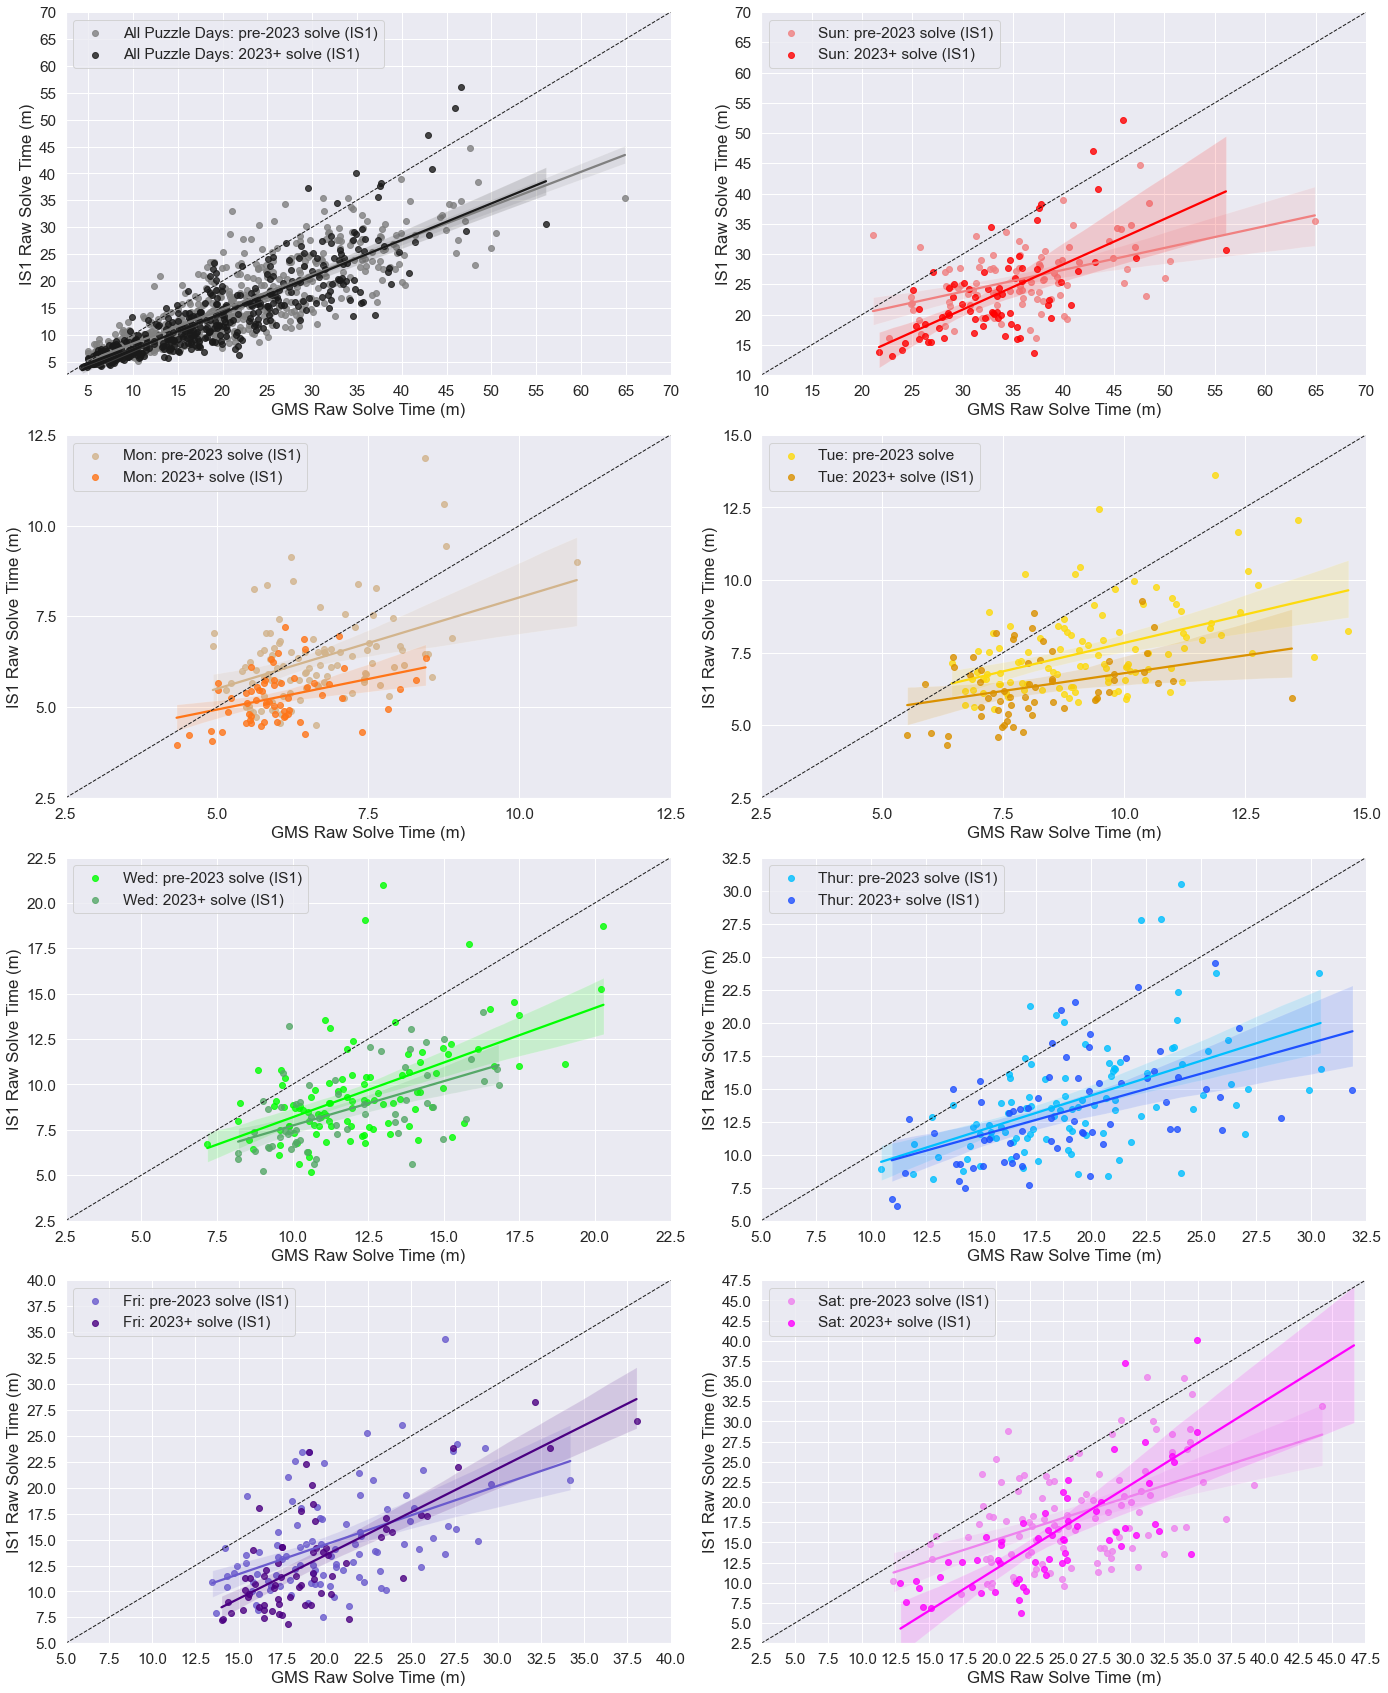

In [52]:
# Scatterplots of individual raw solve times vs global median solve times, per puzzle day
#Figure 4

df_IS1_v2 = df_IS1_v2.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS1_v2['plot_seq_map'] = df_IS1_v2['plot_seq'].map({1: 'All Puzzle Days: pre-2023 solve (IS1)', 2: 'All Puzzle Days: 2023+ solve (IS1)', 3:'Sun: pre-2023 solve (IS1)', 4:'Sun: 2023+ solve (IS1)', 5:'Mon: pre-2023 solve (IS1)', 6:'Mon: 2023+ solve (IS1)', 7:'Tue: pre-2023 solve', 8:'Tue: 2023+ solve (IS1)', 9:'Wed: pre-2023 solve (IS1)', 10:'Wed: 2023+ solve (IS1)', 11:'Thur: pre-2023 solve (IS1)', 12:'Thur: 2023+ solve (IS1)', 13:'Fri: pre-2023 solve (IS1)', 14:'Fri: 2023+ solve (IS1)', 15:'Sat: pre-2023 solve (IS1)', 16:'Sat: 2023+ solve (IS1)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS1_v2, x="GMST(m)", y="IST(m)", hue="plot_seq_map", col="DOW", col_order=["All", "Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["grey", "k", "lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "GMS Raw Solve Time (m)",
    ylabel="IS1 Raw Solve Time (m)", xticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]  
)

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

#Adjust subplots individually
p.axes[0].set_ylim((2.5,70))
p.axes[0].set_xlim((2.5,70))
p.axes[1].set_ylim((10,70))
p.axes[1].set_xlim((10,70))
p.axes[2].set_ylim((2.5,12.5))
p.axes[2].set_xlim((2.5,12.5))
p.axes[3].set_ylim((2.5,15))
p.axes[3].set_xlim((2.5,15))
p.axes[4].set_ylim((2.5,22.5))
p.axes[4].set_xlim((2.5,22.5))
p.axes[5].set_ylim((5,32.5))
p.axes[5].set_xlim((5,32.5))
p.axes[6].set_ylim((5, 40))
p.axes[6].set_xlim((5, 40))
p.axes[7].set_ylim((2.5, 47.5))
p.axes[7].set_xlim((2.5, 47.55))

p.axes[0].set_xticks((5,10,15,20,25,30,35,40,45,50,55,60,65,70))
p.axes[0].set_yticks((5,10,15,20,25,30,35,40,45,50,55,60,65,70))
p.axes[1].set_xticks((10,15,20,25,30,35,40,45,50,55,60,65,70))
p.axes[1].set_yticks((10,15,20,25,30,35,40,45,50,55,60,65,70))

p.axes[0].plot([2.5, 70], [2.5, 70], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([10, 70], [10, 70], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([2.5, 12.5], [2.5, 12.5], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([2.5, 15], [2.5, 15], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([2.5, 22.5], [2.5, 22.5], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([5, 32.5], [5, 32.5], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([5, 40], [5, 40], 'k', linestyle='dashed', linewidth=1)
p.axes[7].plot([2.5, 47.5], [2.5, 47.5], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend()
_= p.axes[1].legend()
_= p.axes[2].legend()
_= p.axes[3].legend()
_= p.axes[4].legend()
_= p.axes[5].legend()
_= p.axes[6].legend()
_= p.axes[7].legend()

In [53]:
# Correlations for pre-2023 for IST vs GMST
# Careful not to use _v2, since that version has duplicated data for plotting only
df_IS1_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0)] #pre-2023 solves only
df_All = df_IS1_pre2023.copy() #all puzzle days
df_Sun = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Sunday")]
df_Mon = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Monday")]
df_Tue = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Tuesday")]
df_Wed = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Wednesday")]
df_Thu = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Thursday")]
df_Fri = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Friday")]
df_Sat = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Saturday")]

print(df_All['IST(m)'].corr(df_All['GMST(m)']))
print(df_Sun['IST(m)'].corr(df_Sun['GMST(m)']))
print(df_Mon['IST(m)'].corr(df_Mon['GMST(m)']))
print(df_Tue['IST(m)'].corr(df_Tue['GMST(m)']))
print(df_Wed['IST(m)'].corr(df_Wed['GMST(m)']))
print(df_Thu['IST(m)'].corr(df_Thu['GMST(m)']))
print(df_Fri['IST(m)'].corr(df_Fri['GMST(m)']))
print(df_Sat['IST(m)'].corr(df_Sat['GMST(m)']))

0.8708540937788053
0.48287604223120356
0.42231976732144166
0.45080653397236986
0.5468294383764816
0.5126321136858961
0.48249780312114043
0.4910588651616659


In [54]:
# Correlations for 2023_24 for IST vs GMST
# Careful not to use _v2, since that version has duplicated data for plotting only
df_IS1_2023_24 = df_IS1.loc[(df_IS1["2023+_solve"] == 1)] #2023-2024 solves only
df_All = df_IS1_2023_24.copy() #all puzzle days
df_Sun = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Sunday")]
df_Mon = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Monday")]
df_Tue = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Tuesday")]
df_Wed = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Wednesday")]
df_Thu = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Thursday")]
df_Fri = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Friday")]
df_Sat = df_IS1_2023_24.loc[df_IS1_2023_24["DOW"]==("Saturday")]

print(df_All['IST(m)'].corr(df_All['GMST(m)']))
print(df_Sun['IST(m)'].corr(df_Sun['GMST(m)']))
print(df_Mon['IST(m)'].corr(df_Mon['GMST(m)']))
print(df_Tue['IST(m)'].corr(df_Tue['GMST(m)']))
print(df_Wed['IST(m)'].corr(df_Wed['GMST(m)']))
print(df_Thu['IST(m)'].corr(df_Thu['GMST(m)']))
print(df_Fri['IST(m)'].corr(df_Fri['GMST(m)']))
print(df_Sat['IST(m)'].corr(df_Sat['GMST(m)']))

0.870518019802786
0.6131951142180242
0.37670447491752257
0.3134271476855222
0.5519155699561974
0.515883339180639
0.7436206170508335
0.7821461802030144


In [55]:
# IS1 vs GMS by Puzzle Day: pre-2023 solves
# Careful not to use _v2, since that version has duplicated data for plotting only

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
All_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(All_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sun_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sun_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Mon_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Mon_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Tue_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Tue_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Wed_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Wed_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Thu_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Thu_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Fri_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Fri_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sat_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sat_IST_win_pct)

86.72199170124482
96.875
63.46153846153846
88.88888888888889
87.96296296296296
91.17647058823529
90.0
89.52380952380953


In [56]:
# Win % for IS1 vs GMS by Puzzle Day: 2023_2024 solves
# Careful not to use _v2, since that version has duplicated data for plotting only

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
All_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(All_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sun_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sun_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Mon_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Mon_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Tue_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Tue_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Wed_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Wed_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Thu_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Thu_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Fri_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Fri_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sat_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sat_IST_win_pct)


90.64587973273942
91.54929577464789
84.12698412698413
85.0
95.0
89.39393939393939
94.02985074626866
95.16129032258065


In [57]:
# Mean difference for raw IST vs GMST pre2023 
# Careful not to use _v2, since that version has duplicated data for plotting only

df_IS1['IST_raw_Diff_GMST'] = (df_IS1['IST(m)'] - df_IS1['GMST(m)'])

print(df_IS1.loc[(df_IS1["2023+_solve"] == 0), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))

          mean
           std
mean -4.608506
std   5.201312
          mean
           std
mean -9.839583
std   6.569228
          mean
           std
mean -0.319712
std   1.209805
          mean
           std
mean -1.779630
std   1.735395
          mean
           std
mean -2.701852
std   2.524555
          mean
           std
mean -5.201961
std   4.163437
          mean
           std
mean -5.687333
std   4.556284
          mean
           std
mean -7.340635
std   5.996178


In [58]:
# Mean difference for raw IST vs GMST 2023_2024 
# Careful not to use _v2, since that version has duplicated data for plotting only
#df_IS1['IST_raw_Diff_GMST'] = (df_IS1['IST(m)'] - df_IS1['GMST(m)'])

print(df_IS1.loc[(df_IS1["2023+_solve"] == 1), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))

          mean
           std
mean -5.247439
std   4.983340
          mean
           std
mean -9.961268
std   6.149342
          mean
           std
mean -0.753704
std   0.861962
          mean
           std
mean -1.815000
std   1.538748
          mean
           std
mean -3.194167
std   2.191638
          mean
           std
mean -5.579293
std   4.087276
          mean
           std
mean -6.428109
std   3.486867
          mean
           std
mean -8.095161
std   5.291283


In [ ]:
#df_IS1 = df_IS1.drop(["IST_raw_Diff_GMST"], axis=1, inplace=True)

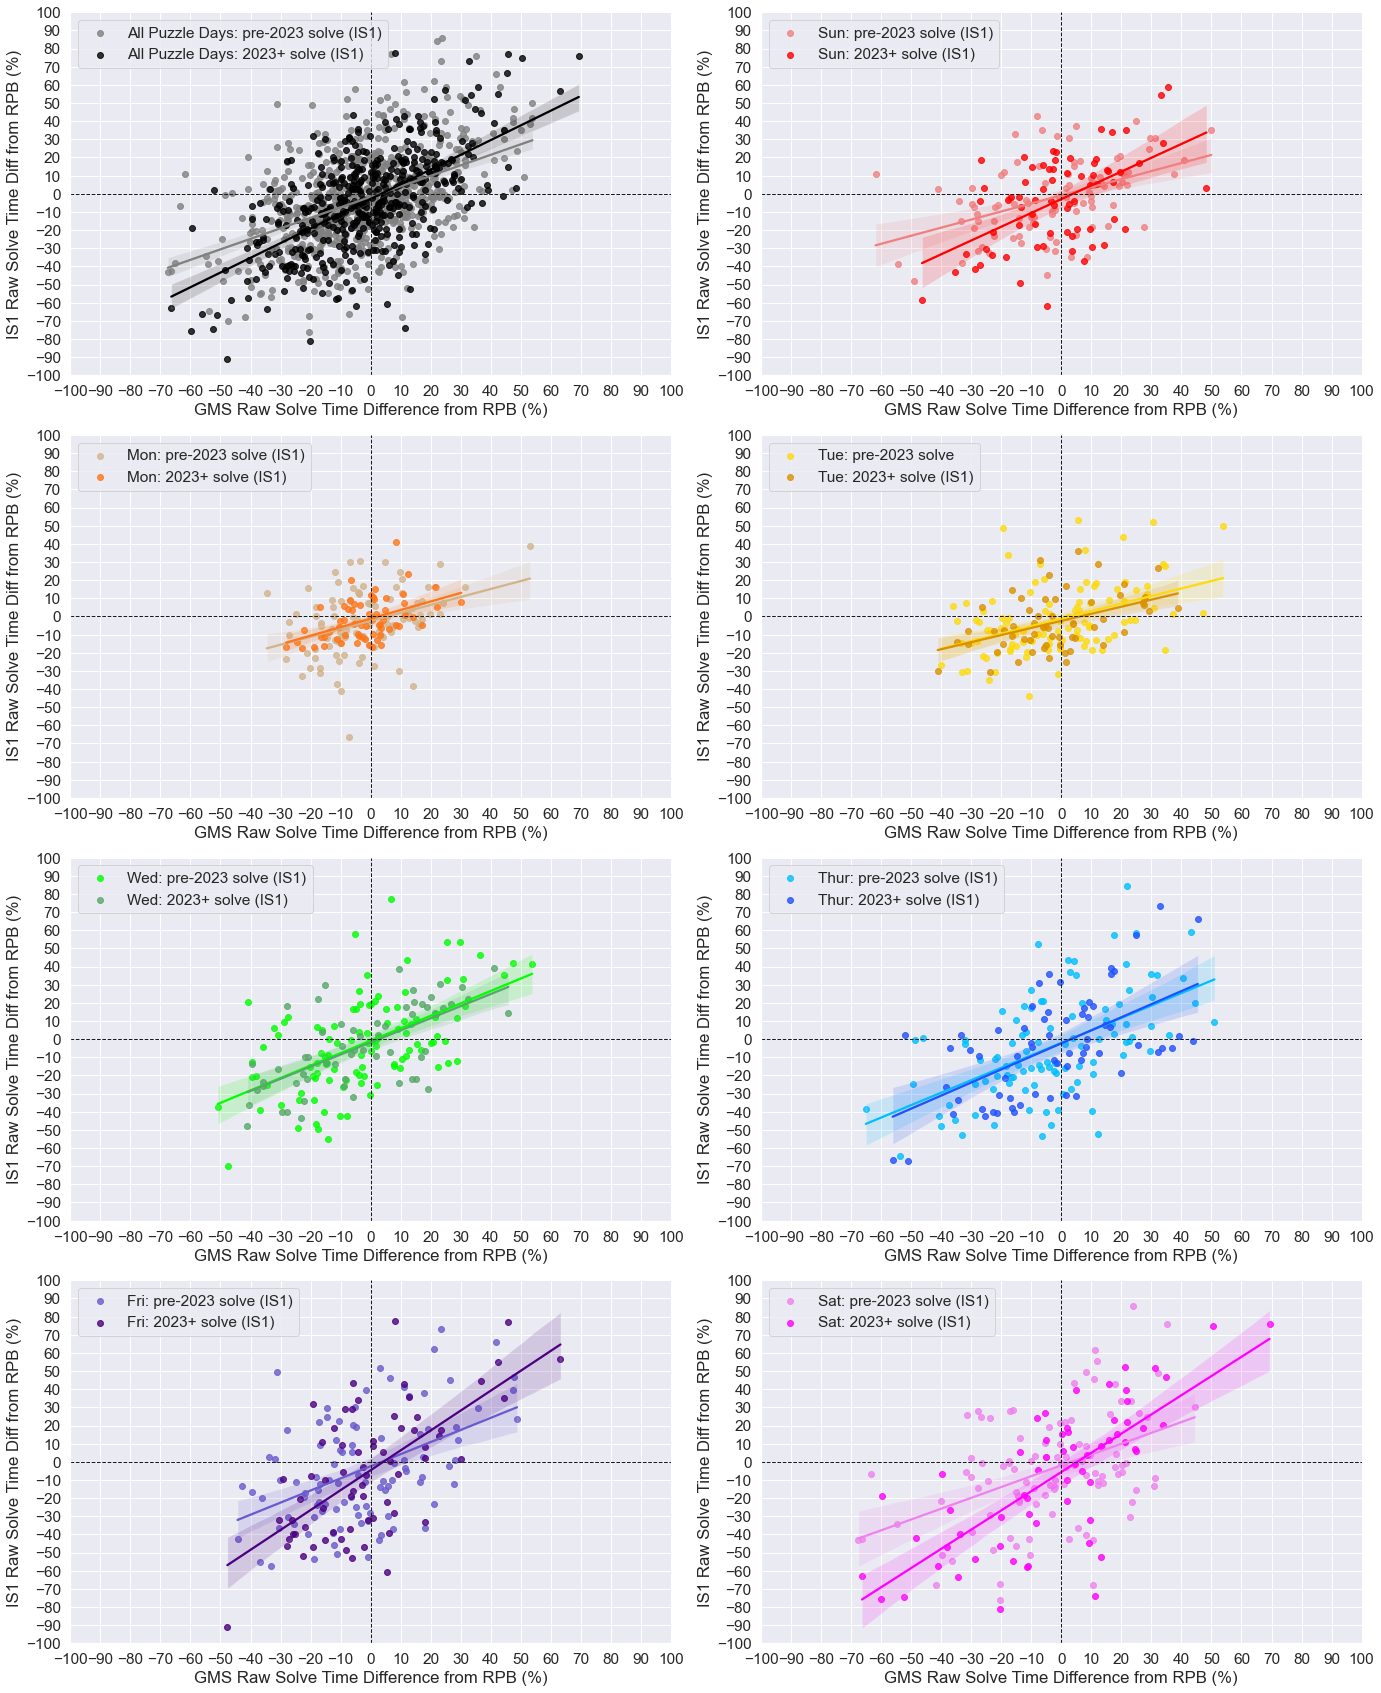

In [59]:
# Scatterplots of difference from time-decay weighted previous 10-puzzle average for individual solver for a given solve vs same for global median solver, per puzzle day
# This isolates RELATIVE performance for the individual solver on a given puzzle vs their recent performance, and how that relative performance compares to that for the median solver

df_IS1_v2 = df_IS1_v2.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS1_v2['plot_seq_map'] = df_IS1_v2['plot_seq'].map({1: 'All Puzzle Days: pre-2023 solve (IS1)', 2: 'All Puzzle Days: 2023+ solve (IS1)', 3:'Sun: pre-2023 solve (IS1)', 4:'Sun: 2023+ solve (IS1)', 5:'Mon: pre-2023 solve (IS1)', 6:'Mon: 2023+ solve (IS1)', 7:'Tue: pre-2023 solve', 8:'Tue: 2023+ solve (IS1)', 9:'Wed: pre-2023 solve (IS1)', 10:'Wed: 2023+ solve (IS1)', 11:'Thur: pre-2023 solve (IS1)', 12:'Thur: 2023+ solve (IS1)', 13:'Fri: pre-2023 solve (IS1)', 14:'Fri: 2023+ solve (IS1)', 15:'Sat: pre-2023 solve (IS1)', 16:'Sat: 2023+ solve (IS1)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS1_v2, x="GMST_Diff%_from_GMS_pds_l10_dw", y="IST_Diff%_from_IS_pds_l10_dw", hue="plot_seq_map", col="DOW", col_order=["All", "Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["grey","black","lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "GMS Raw Solve Time Difference from RPB (%)",
    ylabel="IS1 Raw Solve Time Diff from RPB (%)", xticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100], yticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-100,100))
p.axes[0].set_xlim((-100,100))
p.axes[1].set_ylim((-100,100))
p.axes[1].set_xlim((-100,100))
p.axes[2].set_ylim((-100,100))
p.axes[2].set_xlim((-100,100))
p.axes[3].set_ylim((-100,100))
p.axes[3].set_xlim((-100,100))
p.axes[4].set_ylim((-100,100))
p.axes[4].set_xlim((-100,100))
p.axes[5].set_ylim((-100,100))
p.axes[5].set_xlim((-100,100))
p.axes[6].set_ylim((-100,100))
p.axes[6].set_xlim((-100,100))
p.axes[7].set_ylim((-100,100))
p.axes[7].set_xlim((-100,100))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

p.axes[0].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[0].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[7].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[7].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend(loc = 'upper left')
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [60]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 1 to 895
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   P_Date                          1172 non-null   datetime64[ns]
 1   P_Date_str                      1172 non-null   object        
 2   P_Yr                            1172 non-null   period[A-DEC] 
 3   2023+_puzzle                    1172 non-null   float64       
 4   DOW                             1172 non-null   object        
 5   DOW_num                         1172 non-null   float64       
 6   GMST(m)                         1172 non-null   float64       
 7   GMST(m)_10p_MA                  1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA      1172 non-null   int64         
 9   GMS_pds_l10_dw                  1172 non-null   float64       
 10  GMST_Diff%_from_GMS_pds_l10_dw  1172 non-null   float64       
 11  Comp_

In [61]:
#Quadrant Analysis pre-2023 (note: very very rare exact zero difference puzzles are ignored for this calculation)
# Careful not to use _v2, since that version has duplicated data for plotting only

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

41.25874125874126 25.174825174825177 15.524475524475525 18.041958041958043
41.05263157894737 31.57894736842105 12.631578947368421 14.736842105263156
38.23529411764706 22.54901960784314 20.588235294117645 18.627450980392158
43.925233644859816 25.233644859813083 12.149532710280374 18.69158878504673
41.1214953271028 25.233644859813083 16.822429906542055 16.822429906542055
44.554455445544555 27.722772277227726 11.881188118811881 15.841584158415841
42.42424242424242 21.21212121212121 18.181818181818183 18.181818181818183
37.5 23.076923076923077 16.346153846153847 23.076923076923077


In [62]:
#Quadrant Analysis 2023+ (note: very very rare exact zero difference puzzles are ignored for this calculation)

# Careful not to use _v2, since that version has duplicated data for plotting only

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] > 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST_Diff%_from_IS_pds_l10_dw"] < 0) & (df_IS1["GMST_Diff%_from_GMS_pds_l10_dw"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

39.643652561247215 28.73051224944321 14.253897550111358 17.37193763919822
35.2112676056338 28.169014084507044 18.30985915492958 18.30985915492958
38.095238095238095 23.809523809523807 14.285714285714285 23.809523809523807
43.333333333333336 21.666666666666668 16.666666666666664 18.333333333333332
41.66666666666667 33.33333333333333 11.666666666666666 13.333333333333334
37.878787878787875 22.727272727272727 16.666666666666664 22.727272727272727
44.776119402985074 31.343283582089555 13.432835820895523 10.44776119402985
37.096774193548384 40.32258064516129 8.064516129032258 14.516129032258066


In [63]:
# Correlation analysis pre-2023
# Careful not to use _v2, since that version has duplicated data for plotting only

All_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"]==0)]
print(All_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(All_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Sun_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday")]
print(Sun_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Sun_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Mon_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday")]
print(Mon_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Mon_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Tue_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday")]
print(Tue_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Tue_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Wed_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday")]
print(Wed_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Wed_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Thu_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday")]
print(Thu_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Thu_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Fri_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday")]
print(Fri_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Fri_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

Sat_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday")]
print(Sat_pre2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Sat_pre2023['IST_Diff%_from_IS_pds_l10_dw']))

0.472680728011968
0.45815979616581864
0.3674979276836851
0.4311059647891068
0.5539934729146302
0.5499032108931307
0.467817849062799
0.4315217750126064


In [64]:
# Correlation analysis 2023+
# Careful not to use _v2, since that version has duplicated data for plotting only

All_2023 = df_IS1.loc[(df_IS1["2023+_solve"]==1)]
print(All_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(All_2023['IST_Diff%_from_IS_pds_l10_dw']))

Sun_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday")]
print(Sun_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Sun_2023['IST_Diff%_from_IS_pds_l10_dw']))

Mon_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday")]
print(Mon_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Mon_2023['IST_Diff%_from_IS_pds_l10_dw']))

Tue_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday")]
print(Tue_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Tue_2023['IST_Diff%_from_IS_pds_l10_dw']))

Wed_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday")]
print(Wed_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Wed_2023['IST_Diff%_from_IS_pds_l10_dw']))

Thu_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday")]
print(Thu_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Thu_2023['IST_Diff%_from_IS_pds_l10_dw']))

Fri_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday")]
print(Fri_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Fri_2023['IST_Diff%_from_IS_pds_l10_dw']))

Sat_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday")]
print(Sat_2023['GMST_Diff%_from_GMS_pds_l10_dw'].corr(Sat_2023['IST_Diff%_from_IS_pds_l10_dw']))

0.6154402301310362
0.5455855892141034
0.4651822200077949
0.44935858737205586
0.657352210814009
0.5884782594873325
0.6398091955055928
0.741565142396746


In [ ]:
df_IS1.drop(['plot_seq', 'plot_seq_map'], axis=1, inplace=True)

### Constructor Analysis
Which constructors does individual solver 1 (IS1) struggle against? Which ones does IS1 do well against? This analysis is with respect to average deviation for solve performance on given puzzle from recent (time-weighted) performance per constructor/constructor team (aligns with what we have available for the global median solver). 

In [65]:
# Get stats for Individual Solver
constructor_avgs_IS = df_IS1.groupby(['Constructors'])['IST_Diff%_from_IS_pds_l10_dw'].agg(constructor_mean_IS=(np.mean), puzzle_count_IS=(np.count_nonzero))
constructor_avgs_IS["constructor_mean_IS"] = constructor_avgs_IS["constructor_mean_IS"].round(2)

#Get stats for Global Mean Solver
constructor_avgs_GMT = df_IS1.groupby(['Constructors'])['GMST_Diff%_from_GMS_pds_l10_dw'].agg(constructor_mean_GMS=(np.mean), puzzle_count_GMS=(np.count_nonzero))
constructor_avgs_GMT["constructor_mean_GMS"] = constructor_avgs_GMT["constructor_mean_GMS"].round(2)

#Merge Individual and Global Mean stats into single df
constructor_avgs = constructor_avgs_IS.merge(constructor_avgs_GMT, on='Constructors', how='inner')

puzzle_min_threshold = 4 #min number of puzzles in sample for constructor/constructor team to be kept in the analysis 

# Pare down to only constructor(s) with at least n puzzles for which IS1 has completed
constructor_avgs_filter = constructor_avgs.loc[constructor_avgs['puzzle_count_IS'] >= puzzle_min_threshold] 

In [66]:
constructor_avgs_filter.head(35)

constructor_mean_IS  \
Constructors                                                      
Aaron M. Rosenberg                                        -7.81   
Adam Aaronson                                            -14.27   
Adam Wagner                                                1.93   
Adrian Johnson                                            20.15   
Aimee Lucido                                             -27.33   
Alex Eaton-Salners                                        15.59   
Andrea Carla Michaels and Kevin Christian                 -8.23   
Barbara Lin                                               -3.45   
Billy Bratton                                            -18.48   
Blake Slonecker                                          -11.93   
Brad Wiegmann                                            -11.85   
Brandon Koppy                                             -1.24   
Bruce Haight                                              19.00   
Byron Walden                                              -5.70   
Claire Rimkus                                              5.73   
Damon Gulczynski                                          -1.87   
Dan Schoenholz                                            -5.70   
David Distenfeld                                          -4.30   
David Steinberg                                          -16.90   
David Tuffs                                                7.69   
Drew Schmenner                                            -1.69   
Ella Dershowitz                                           13.26   
Ella Dershowitz and Aimee Lucido                           1.73   
Emily Carroll                                             -9.04   
Enrique Henestroza Anguiano                              -26.91   
Eric Bornstein                                           -13.27   
Erik Agard                                                -3.62   
Freddie Cheng                                            -24.26   
Garrett Chalfin                                           -2.99   
Gia Bosko                                                 -5.03   
Grant Thackray                                            -3.70   
Hemant Mehta                                             -13.17   
Jacob McDermott                                            6.18   
Jake Halperin                                             -0.34   
Jem Burch                                                  7.90   

                                            puzzle_count_IS  \
Constructors                                                  
Aaron M. Rosenberg                                      4.0   
Adam Aaronson                                           7.0   
Adam Wagner                                            14.0   
Adrian Johnson                                          5.0   
Aimee Lucido                                            5.0   
Alex Eaton-Salners                                      9.0   
Andrea Carla Michaels and Kevin Christian               4.0   
Barbara Lin                                             8.0   
Billy Bratton                                           5.0   
Blake Slonecker                                         6.0   
Brad Wiegmann                                           6.0   
Brandon Koppy                                          12.0   
Bruce Haight                                            8.0   
Byron Walden                                            8.0   
Claire Rimkus                                           4.0   
Damon Gulczynski                                        6.0   
Dan Schoenholz                                          4.0   
David Distenfeld                                        7.0   
David Steinberg                                         9.0   
David Tuffs                                             6.0   
Drew Schmenner                                          5.0   
Ella Dershowitz                                         4.0   
Ella Dershowitz and Aimee Lucido                    

In [67]:
constructor_avgs_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, Aaron M. Rosenberg to Zhouqin Burnikel
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   constructor_mean_IS   74 non-null     float64
 1   puzzle_count_IS       74 non-null     float64
 2   constructor_mean_GMS  74 non-null     float64
 3   puzzle_count_GMS      74 non-null     float64
dtypes: float64(4)
memory usage: 2.9+ KB


74/559 (13%) constructor(s) had 4+ puzzles in the puzzle set completed by IS1. However, 40% puzzles completed by IS1 were created by that 13% of constructor(s)! Overall, repeat constructors accounted for 72% puzzles in those completed by IS1. 

In [85]:
constructor_avgs_filter.to_csv('../data/constructor_avgs_filter.csv', index=True)

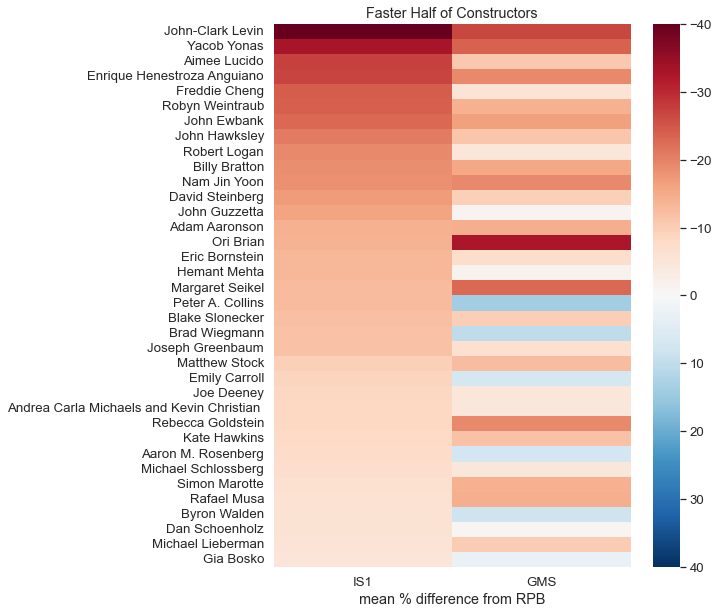

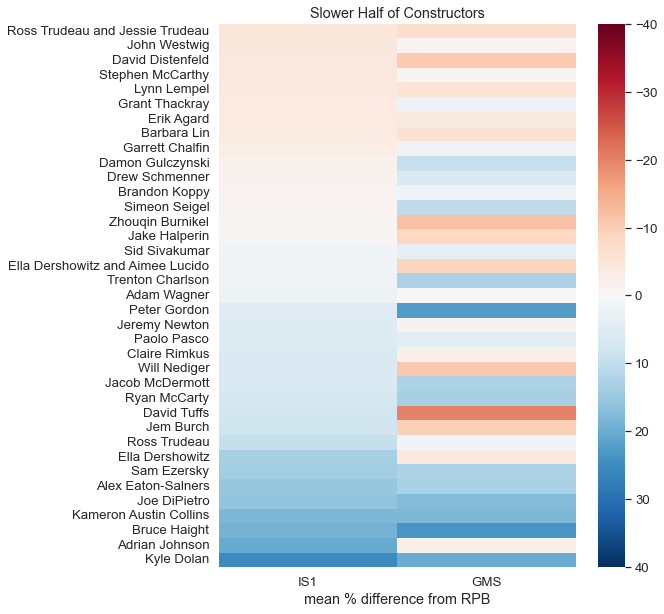

In [68]:
# Construct Heat Map sorted by fastest constructor relative to Individual solver 10 puzzle moving average to slowest

#Remove puzzle ns columns and sort for heatmapping
avgs = constructor_avgs_filter[["constructor_mean_IS", "constructor_mean_GMS"]]
avgs = avgs.sort_values(by=['constructor_mean_IS'], ascending = True)

first_half_end = int((len(avgs)/2)-1)
avgs_end = int(len(avgs))
first_half = avgs[0:first_half_end]
second_half = avgs[(first_half_end+1):avgs_end]

first_half = first_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(8,10))
sns.set(font_scale=1.2)
ax = sns.heatmap(first_half, xticklabels=['IS1', 'GMS'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.xlabel('mean % difference from RPB')
plt.ylabel('')
plt.title("Faster Half of Constructors")
plt.show()

second_half = second_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(8,10))
sns.set(font_scale=1.2)
ax2 = sns.heatmap(second_half, xticklabels=['IS1', 'GMS'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.xlabel('mean % difference from RPB')
plt.ylabel('')
plt.title("Slower Half of Constructors")
plt.show()

In [69]:
print(constructor_avgs_filter[["constructor_mean_IS"]].agg(['min', 'max']))
print(constructor_avgs_filter[["constructor_mean_GMS"]].agg(['min', 'max']))

     constructor_mean_IS
min               -41.86
max                25.39
     constructor_mean_GMS
min                -32.76
max                 23.54


In [70]:
# Calculate past performance (using COMP date to sort) for IS1 against a given constructor (% difference from RPB) for each puzzle in sample
# Individual Solver mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days
# Getting the count as well will allow filtering by past number of puzzles for a second version of the figure

df_IS1 = df_IS1.sort_values(by=['Constructors','Comp_Date'], ascending = False)

df_IS1 = df_IS1.iloc[::-1]
df_IS1['IS_per_constr_avg_past_diff_from_RPB'] = df_IS1.groupby(['Constructors'])['IST_Diff%_from_IS_pds_l10_dw'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
df_IS1['IS_per_constr_past_diff_from_RPB_ct'] = df_IS1.groupby(['Constructors'])['IST_Diff%_from_IS_pds_l10_dw'].transform(lambda x: x.rolling(window=100, min_periods = 1).count().shift(1))
df_IS1 = df_IS1.iloc[::-1]

# col = df_IS1.pop('GMS_per_constr_avg_past_diff_from_10pMA')
# df_IS1.insert(17, col.name, col)

In [ ]:
# Checkpoint
df_IS1.to_csv('../data/df_IS1.csv', index=False)

In [71]:
# Create df that includes only puzzles with Constructor(s) where there are >=3 prior puzzles by them
df_IS1_filter = df_IS1.loc[(df_IS1["IS_per_constr_past_diff_from_RPB_ct"] >= 3)]
df_IS1_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 990 to 198
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   P_Date                                242 non-null    datetime64[ns]
 1   P_Date_str                            242 non-null    object        
 2   P_Yr                                  242 non-null    period[A-DEC] 
 3   2023+_puzzle                          242 non-null    float64       
 4   DOW                                   242 non-null    object        
 5   DOW_num                               242 non-null    float64       
 6   GMST(m)                               242 non-null    float64       
 7   GMST(m)_10p_MA                        242 non-null    float64       
 8   GMST_Diff%_from_GMS_10p_MA            242 non-null    int64         
 9   GMS_pds_l10_dw                        242 non-null    float64       
 10  

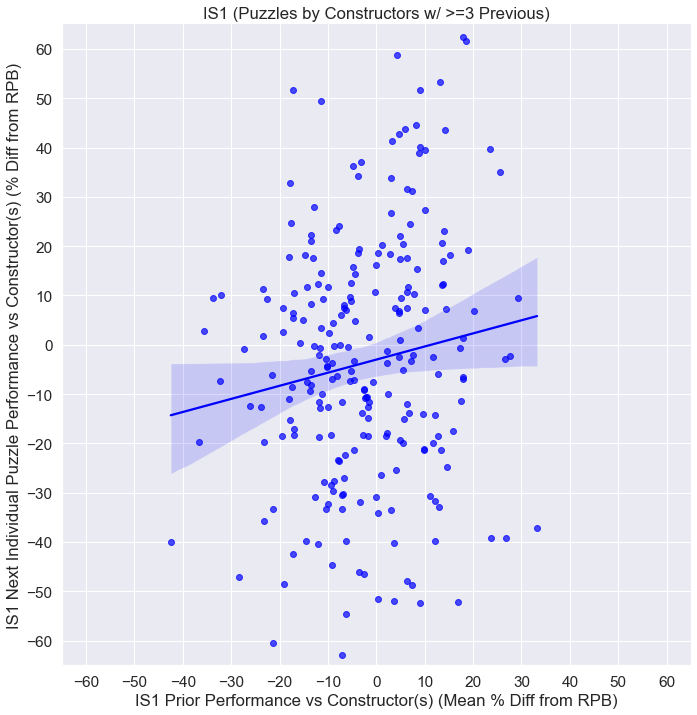

In [72]:
#Plot IS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(IS) for all puzzles whose constructor had at least 3 prior puzzles in the sample
# Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_IS1_filter, x="IS_per_constr_avg_past_diff_from_RPB", y="IST_Diff%_from_IS_pds_l10_dw",
    height=10, aspect=1, legend=False, scatter_kws = {"color": "blue", "alpha": 0.7}, line_kws = {"color": "blue"}
).set(title="IS1 (Puzzles by Constructors w/ >=3 Previous)", xlabel= "IS1 Prior Performance vs Constructor(s) (Mean % Diff from RPB)",
    ylabel="IS1 Next Individual Puzzle Performance vs Constructor(s) (% Diff from RPB)", xticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60], yticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60]
)

# #Adjust subplots individually
_= p.set(ylim=(-65, 65))
_= p.set(xlim=(-65, 65))

In [73]:
# Correlation Calculation (Pearson r)
print(df_IS1_filter['IS_per_constr_avg_past_diff_from_RPB'].corr(df_IS1_filter['IST_Diff%_from_IS_pds_l10_dw']))

0.1274496366465296


In [74]:
# Calculate past performance (using COMP date to sort) for GMS against a given constructor (% difference from DTW last 10-puzzle moving average) for each puzzle in sample
# GMS mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from DTW last 10-puzzle moving average, so that it can be collapsed across puzzle days
# Getting the count as well will allow filtering by past number of puzzles for a second version of the figure

df_IS1 = df_IS1.sort_values(by=['Constructors','Comp_Date'], ascending = False)

df_IS1 = df_IS1.iloc[::-1]
df_IS1['GMS_per_constr_avg_past_diff_from_RPB'] = df_IS1.groupby(['Constructors'])['GMST_Diff%_from_GMS_pds_l10_dw'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
df_IS1['GMS_per_constr_past_diff_from_RPB_ct'] = df_IS1.groupby(['Constructors'])['GMST_Diff%_from_GMS_pds_l10_dw'].transform(lambda x: x.rolling(window=100, min_periods = 1).count().shift(1))
df_IS1 = df_IS1.iloc[::-1]

# col = df_IS1.pop('GMS_per_constr_avg_past_diff_from_10pMA')
# df_IS1.insert(17, col.name, col)

In [75]:
# Create df that includes only puzzles with Constructor(s) where there are >=3 prior puzzles by them
df_IS1_filter = df_IS1.loc[(df_IS1["GMS_per_constr_past_diff_from_RPB_ct"] >= 3)]
df_IS1_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 990 to 198
Data columns (total 52 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   P_Date                                 246 non-null    datetime64[ns]
 1   P_Date_str                             246 non-null    object        
 2   P_Yr                                   246 non-null    period[A-DEC] 
 3   2023+_puzzle                           246 non-null    float64       
 4   DOW                                    246 non-null    object        
 5   DOW_num                                246 non-null    float64       
 6   GMST(m)                                246 non-null    float64       
 7   GMST(m)_10p_MA                         246 non-null    float64       
 8   GMST_Diff%_from_GMS_10p_MA             246 non-null    int64         
 9   GMS_pds_l10_dw                         246 non-null    float64 

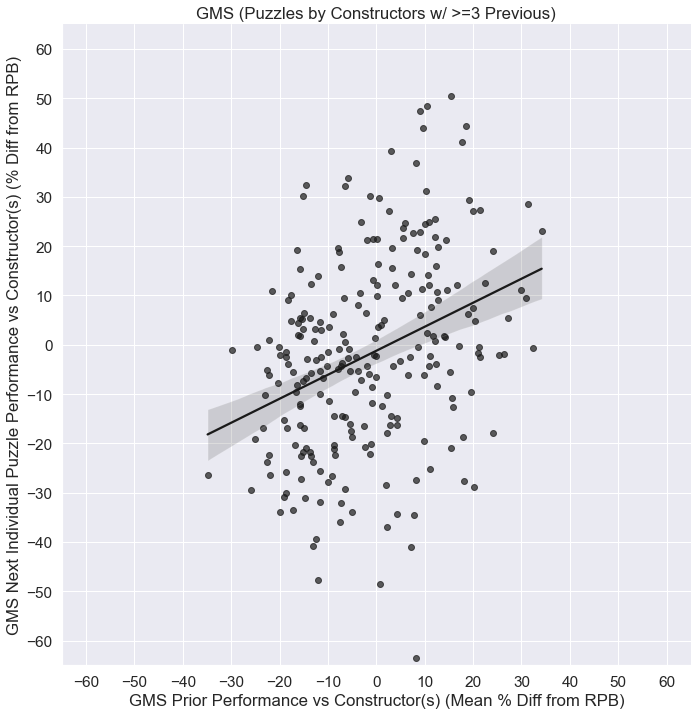

In [76]:
#Plot GMS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(GMS) for all puzzles whose constructor had at least 4 prior puzzles in the sample
# Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_IS1_filter, x="GMS_per_constr_avg_past_diff_from_RPB", y="GMST_Diff%_from_GMS_pds_l10_dw",
    height=10, aspect=1, legend=False, scatter_kws = {"color": "k", "alpha": 0.7}, line_kws = {"color": "k"}
).set(title="GMS (Puzzles by Constructors w/ >=3 Previous)", xlabel= "GMS Prior Performance vs Constructor(s) (Mean % Diff from RPB)",
    ylabel="GMS Next Individual Puzzle Performance vs Constructor(s) (% Diff from RPB)", xticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60], yticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60]
)

# #Adjust subplots individually
_= p.set(ylim=(-65, 65))
_= p.set(xlim=(-65, 65))

In [77]:
# Correlation Calculation (Pearson r)
print(df_IS1_filter['GMS_per_constr_avg_past_diff_from_RPB'].corr(df_IS1_filter['GMST_Diff%_from_GMS_pds_l10_dw']))

0.33619751396429015


### Completion Time of Day Analysis

In [78]:
IS1_df2 = df_IS1.copy()

In [79]:
#Creates a column where Individual Solver completion timestamps are binned to the hour in 24-hour cycle
IS1_df2['Comp_Hr'] = IS1_df2['Comp_Date'].dt.hour
IS1_df2['Comp_Hr'].value_counts()
IS1_df2['Comp_Hr']= IS1_df2['Comp_Hr'].astype('int64')
IS1_df2 = IS1_df2.sort_values('Comp_Hr')

In [80]:
IS1_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 274 to 134
Data columns (total 53 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   P_Date                                 1172 non-null   datetime64[ns]
 1   P_Date_str                             1172 non-null   object        
 2   P_Yr                                   1172 non-null   period[A-DEC] 
 3   2023+_puzzle                           1172 non-null   float64       
 4   DOW                                    1172 non-null   object        
 5   DOW_num                                1172 non-null   float64       
 6   GMST(m)                                1172 non-null   float64       
 7   GMST(m)_10p_MA                         1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA             1172 non-null   int64         
 9   GMS_pds_l10_dw                         1172 non-null   float64

In [81]:
col = IS1_df2.pop('Comp_Hr')
IS1_df2.insert(9, col.name, col)

In [82]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023+

IS1_df2.loc[(IS1_df2["DOW"] == "Sunday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 1 
IS1_df2.loc[(IS1_df2["DOW"] == "Sunday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 2
IS1_df2.loc[(IS1_df2["DOW"] == "Monday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 3 
IS1_df2.loc[(IS1_df2["DOW"] == "Monday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 4
IS1_df2.loc[(IS1_df2["DOW"] == "Tuesday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 5 
IS1_df2.loc[(IS1_df2["DOW"] == "Tuesday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 6
IS1_df2.loc[(IS1_df2["DOW"] == "Wednesday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 7 
IS1_df2.loc[(IS1_df2["DOW"] == "Wednesday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 8
IS1_df2.loc[(IS1_df2["DOW"] == "Thursday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 9 
IS1_df2.loc[(IS1_df2["DOW"] == "Thursday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 10
IS1_df2.loc[(IS1_df2["DOW"] == "Friday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 11 
IS1_df2.loc[(IS1_df2["DOW"] == "Friday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 12
IS1_df2.loc[(IS1_df2["DOW"] == "Saturday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 13 
IS1_df2.loc[(IS1_df2["DOW"] == "Saturday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 14

In [83]:
# For subplot collapsed across puzzle days for puzzle completions by hour of day, make a copy of all data, label it '0' and concatenate with
#main df

IS1_df2_copy = IS1_df2.copy()
IS1_df2_copy["DOW_num"] = 0

IS1_df2a = pd.concat([IS1_df2, IS1_df2_copy],ignore_index=True)

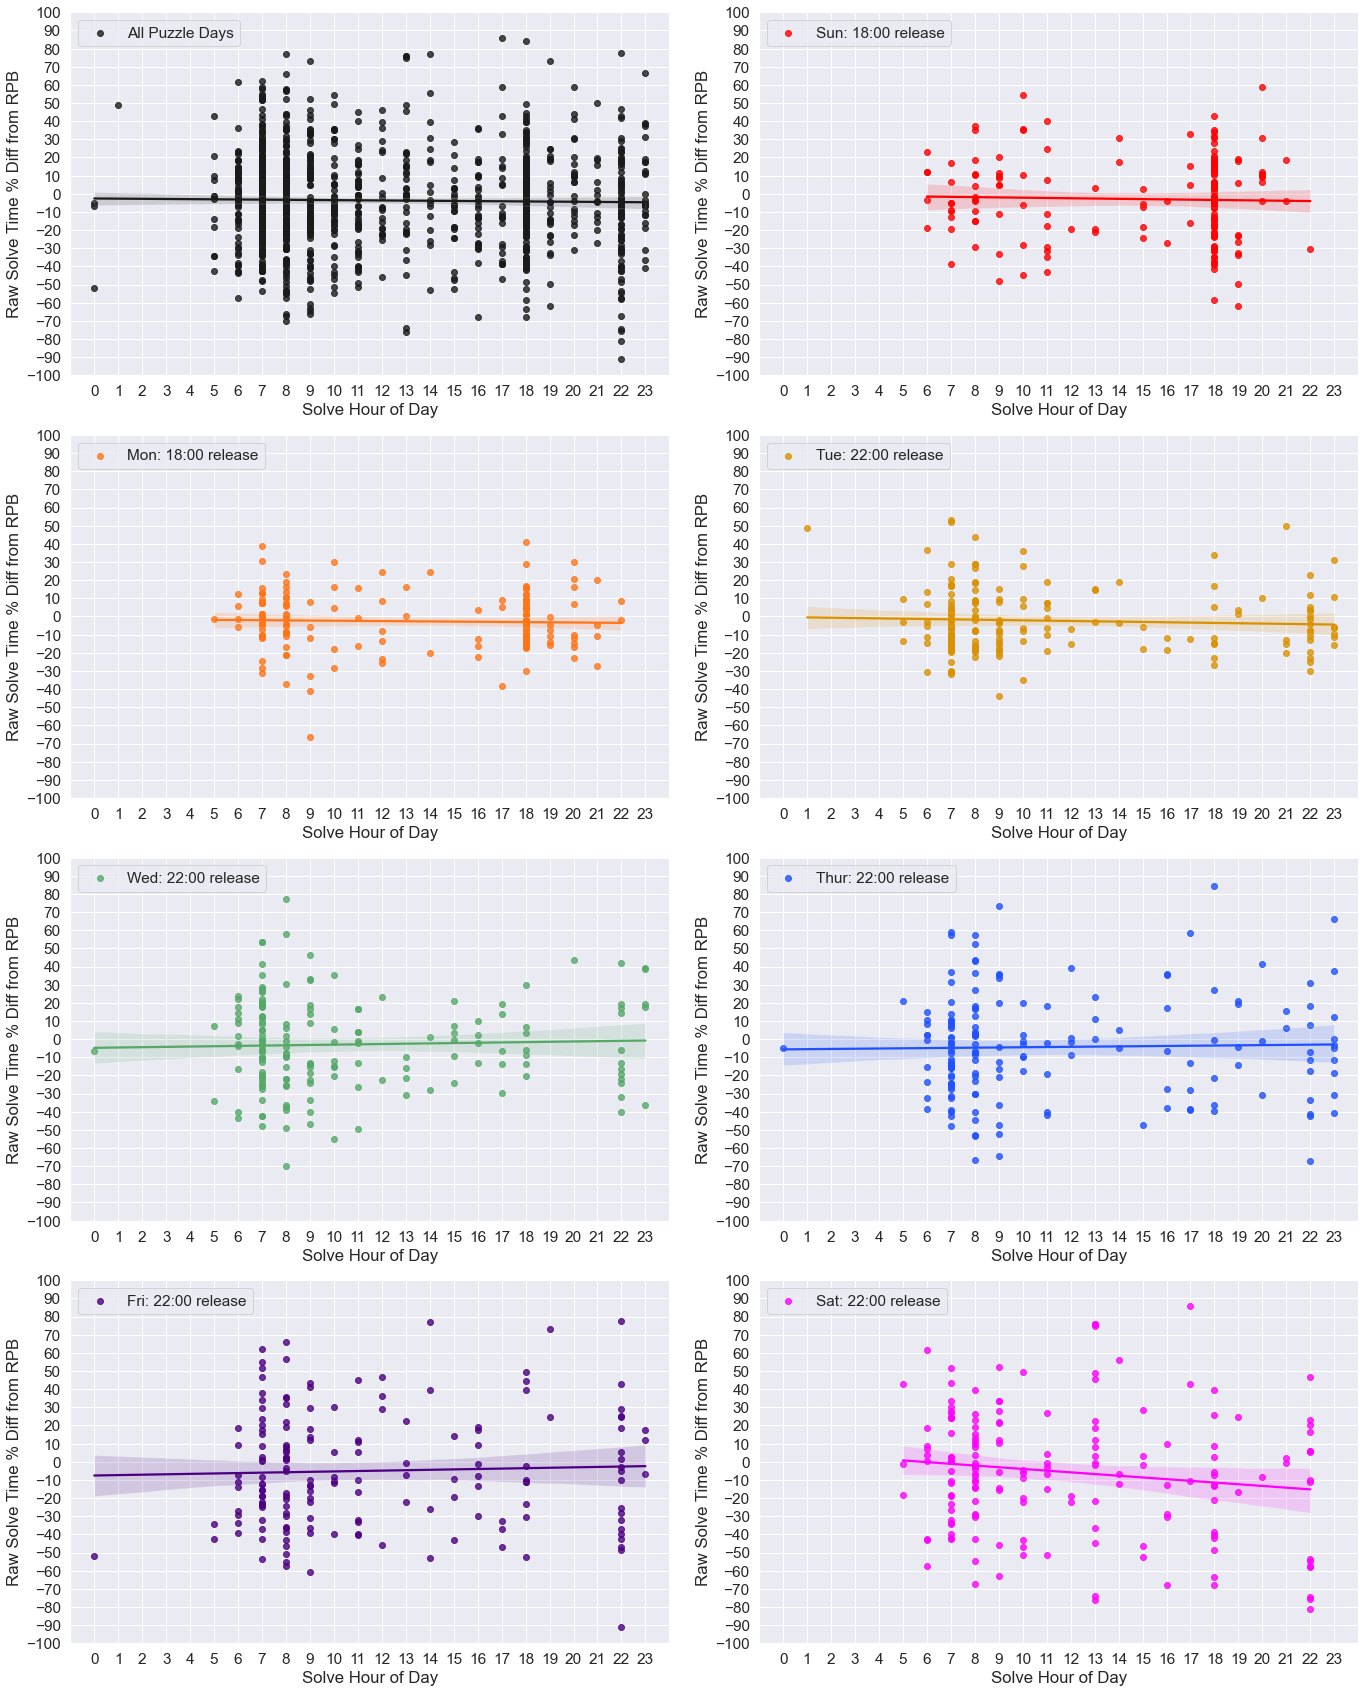

In [84]:
# Individual Solver 1 (IS1) Puzzle Completions by Solve Hour

IS1_df2a = IS1_df2a.sort_values(by=['DOW_num'], ascending = True)

IS1_df2a['plot_seq_map'] = IS1_df2a['DOW_num'].map({0: 'All Puzzle Days', 1:'Sun: 18:00 release', 2:'Mon: 18:00 release', 3:'Tue: 22:00 release', 4:'Wed: 22:00 release', 5: 'Thur: 22:00 release', 6:'Fri: 22:00 release', 7:'Sat: 22:00 release'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df2a, x="Comp_Hr", y="IST_Diff%_from_IS_pds_l10_dw", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], col_wrap=2, palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Solve Hour of Day",
    ylabel="Raw Solve Time % Diff from RPB", yticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100], xticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-100,100))
p.axes[0].set_xlim((-1,24))
p.axes[1].set_ylim((-100,100))
p.axes[1].set_xlim((-1,24))
p.axes[2].set_ylim((-100,100))
p.axes[2].set_xlim((-1,24))
p.axes[3].set_ylim((-100,100))
p.axes[3].set_xlim((-1,24))
p.axes[4].set_ylim((-100,100))
p.axes[4].set_xlim((-1,24))
p.axes[5].set_ylim((-100,100))
p.axes[5].set_xlim((-1,24))
p.axes[6].set_ylim((-100,100))
p.axes[6].set_xlim((-1,24))
p.axes[7].set_ylim((-100,100))
p.axes[7].set_xlim((-1,24))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

IS1_df2a.drop(['plot_seq_map'], axis=1, inplace=True)

In [85]:
#counts of common hours for puzzle completion for IS1
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] >= 18)]))
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] >= 21)]))
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] >= 0)]))
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] >= 7) & (IS1_df2["Comp_Hr"] <= 8)]))

339
116
1172
413


In [86]:
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] >= 6) & (IS1_df2["Comp_Hr"] <= 10)]))

614


In [87]:
#compare very fast solves in 2200 hour with very fast solves across entire cycle
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] == 22)]))
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] != 22)]))

print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] == 22) & (IS1_df2["IST_Diff%_from_IS_pds_l10_dw"] <= -50)]))
print(len(IS1_df2.loc[(IS1_df2["Comp_Hr"] != 22) & (IS1_df2["IST_Diff%_from_IS_pds_l10_dw"] <= -50)]))

77
1095
9
30


### Correlation of Puzzle, Answer and Past Performance Feature Parameters to Individual IS1 Puzzle Solve Times 

In [88]:
# Make a deep copy of individual solver df
IS1_df3 = IS1_df2.copy()

In [89]:
IS1_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 274 to 134
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   P_Date                                 1172 non-null   datetime64[ns]
 1   P_Date_str                             1172 non-null   object        
 2   P_Yr                                   1172 non-null   period[A-DEC] 
 3   2023+_puzzle                           1172 non-null   float64       
 4   DOW                                    1172 non-null   object        
 5   DOW_num                                1172 non-null   float64       
 6   GMST(m)                                1172 non-null   float64       
 7   GMST(m)_10p_MA                         1172 non-null   float64       
 8   GMST_Diff%_from_GMS_10p_MA             1172 non-null   int64         
 9   Comp_Hr                                1172 non-null   int64  

In [ ]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the feature correlation scatterplot figures 

# IS1_df3_copy = IS1_df3.loc[(IS1_df3["DOW_num"] != 1)] #15x15 only
# IS1_df3_copy["DOW_num"] = 0

# IS1_df3a = pd.concat([IS1_df3, IS1_df3_copy],ignore_index=True)

In [ ]:
#IS1_df3a.to_csv('../data/IS1_df3a.csv', index=False)

In [90]:
# Restricting time range to beginning of 2022 onward to minimize baseline solve time (RPB) shift effects on correlations to puzzle features

IS1_df4 = IS1_df3.loc[(IS1_df3["Comp_Yr"]==("2022")) | (IS1_df3["Comp_Yr"]==("2023")) | (IS1_df3["Comp_Yr"]==("2024"))]

# #print(df_IS1.loc[df_IS1["Comp_Yr"]==("2021"), "IST(m)"].sum())

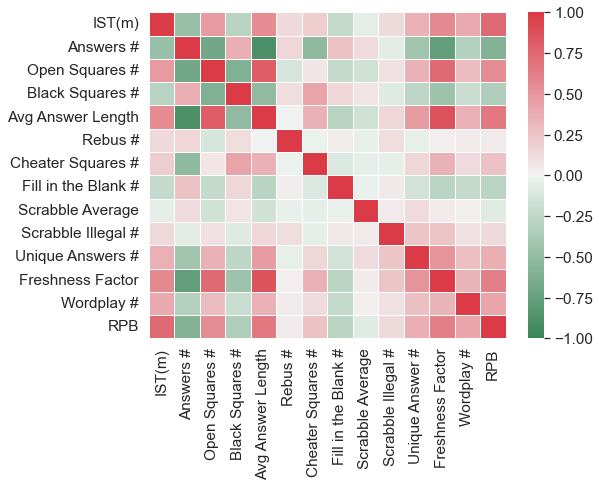

In [91]:
# 15x15 Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]
puzzle_features = IS1_15x15[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'RPB'
}

corr = corr.rename(labels)

# remove the top right triangle - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #','RPB'])
#_= ans.set_yticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Recent Adj Perf', 'Past Perf vs Constructor(s)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [92]:
IS1_15x15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808 entries, 274 to 134
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   P_Date                                 808 non-null    datetime64[ns]
 1   P_Date_str                             808 non-null    object        
 2   P_Yr                                   808 non-null    period[A-DEC] 
 3   2023+_puzzle                           808 non-null    float64       
 4   DOW                                    808 non-null    object        
 5   DOW_num                                808 non-null    float64       
 6   GMST(m)                                808 non-null    float64       
 7   GMST(m)_10p_MA                         808 non-null    float64       
 8   GMST_Diff%_from_GMS_10p_MA             808 non-null    int64         
 9   Comp_Hr                                808 non-null    int64   

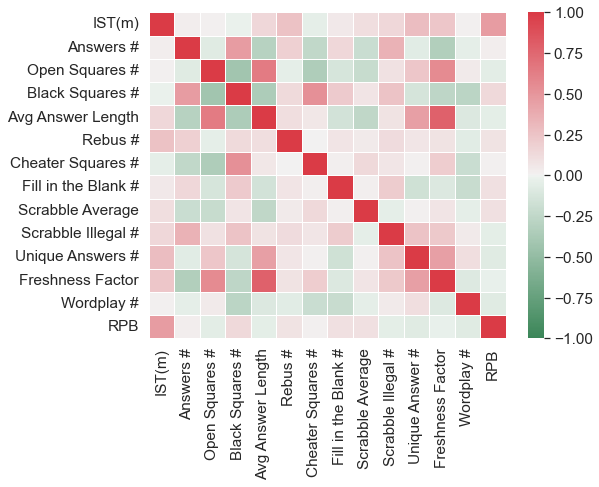

In [93]:
# 21x21 (Sunday) Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_21x21 = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
puzzle_features = IS1_21x21[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'RPB'    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [94]:
IS1_21x21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 1159 to 620
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   P_Date                                 134 non-null    datetime64[ns]
 1   P_Date_str                             134 non-null    object        
 2   P_Yr                                   134 non-null    period[A-DEC] 
 3   2023+_puzzle                           134 non-null    float64       
 4   DOW                                    134 non-null    object        
 5   DOW_num                                134 non-null    float64       
 6   GMST(m)                                134 non-null    float64       
 7   GMST(m)_10p_MA                         134 non-null    float64       
 8   GMST_Diff%_from_GMS_10p_MA             134 non-null    int64         
 9   Comp_Hr                                134 non-null    int64  

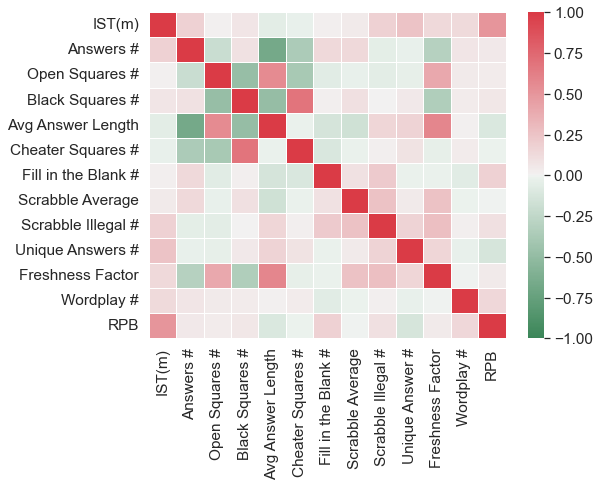

In [95]:
# Monday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df4_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
puzzle_features = IS1_df4_Mon[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'RPB',    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [96]:
IS1_df4_Mon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 423 to 59
Data columns (total 54 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   P_Date                                 133 non-null    datetime64[ns]
 1   P_Date_str                             133 non-null    object        
 2   P_Yr                                   133 non-null    period[A-DEC] 
 3   2023+_puzzle                           133 non-null    float64       
 4   DOW                                    133 non-null    object        
 5   DOW_num                                133 non-null    float64       
 6   GMST(m)                                133 non-null    float64       
 7   GMST(m)_10p_MA                         133 non-null    float64       
 8   GMST_Diff%_from_GMS_10p_MA             133 non-null    int64         
 9   Comp_Hr                                133 non-null    int64    

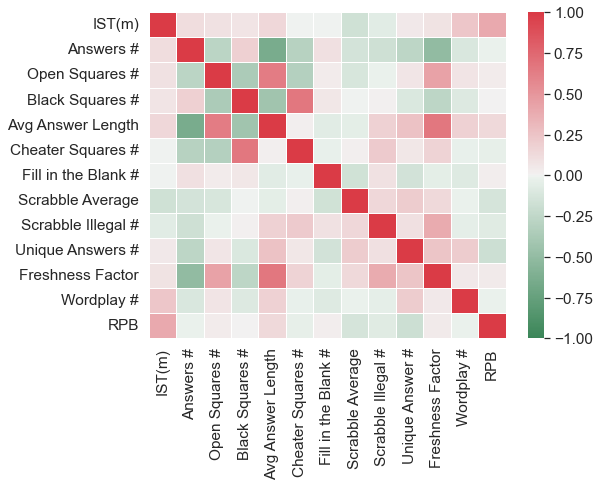

In [97]:
# Tuesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df4_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
puzzle_features = IS1_df4_Tue[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'IS_pds_l10_dw': 'RPB'    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

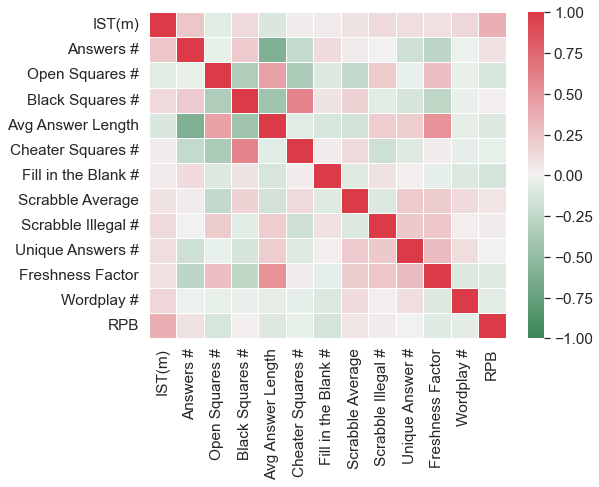

In [98]:
# Wednesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df4_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
puzzle_features = IS1_df4_Wed[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'IS_pds_l10_dw': 'RPB'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

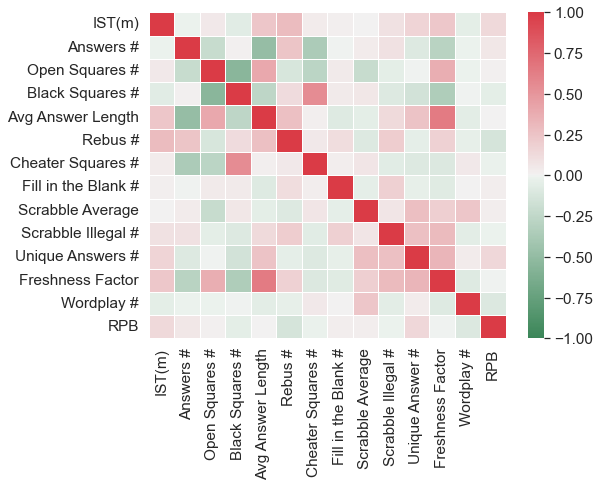

In [99]:
# Thursday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df4_Thurs = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
puzzle_features = IS1_df4_Thurs[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'RPB',    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])
#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

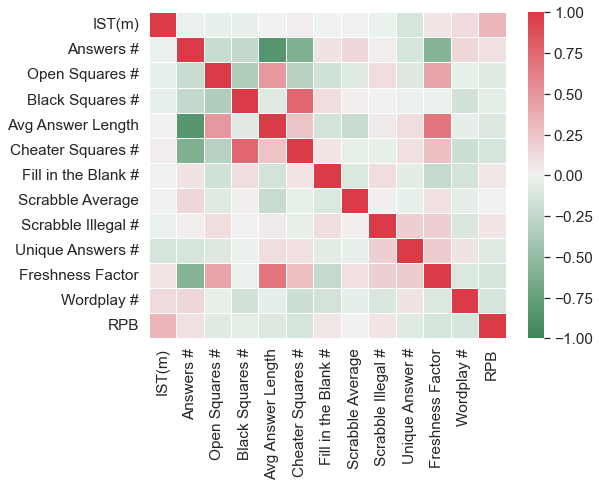

In [100]:
# Friday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df4_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
puzzle_features = IS1_df4_Fri[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'RPB'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

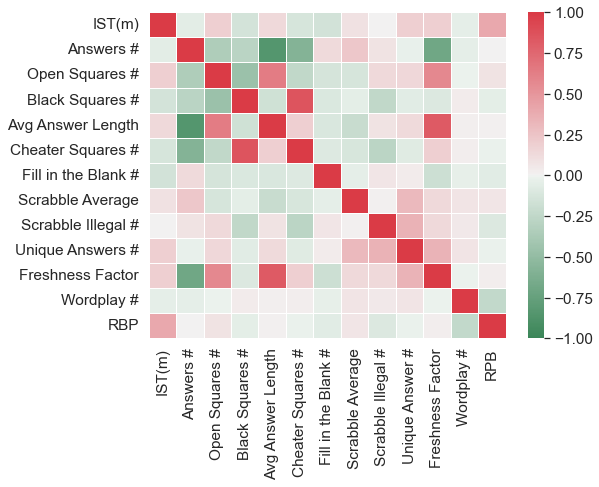

In [101]:
# Saturday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df4_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
puzzle_features = IS1_df4_Sat[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Avg Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'RBP'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Avg Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'RPB'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

### Scatterplots of Relationship of Grid, Answer and Past-Performance Parameters to IS1 Per Puzzle Performance

In [ ]:
IS1_df4.info()

In [102]:
# Create new df with all 15x15 puzzle rows (in the previously filtered date range) copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the feature correlation scatterplot figures 

IS1_df4_copy = IS1_df4.loc[(IS1_df4["DOW_num"] != 1)] #15x15 only
IS1_df4_copy["DOW_num"] = 0

IS1_df4a = pd.concat([IS1_df4, IS1_df4_copy],ignore_index=True)

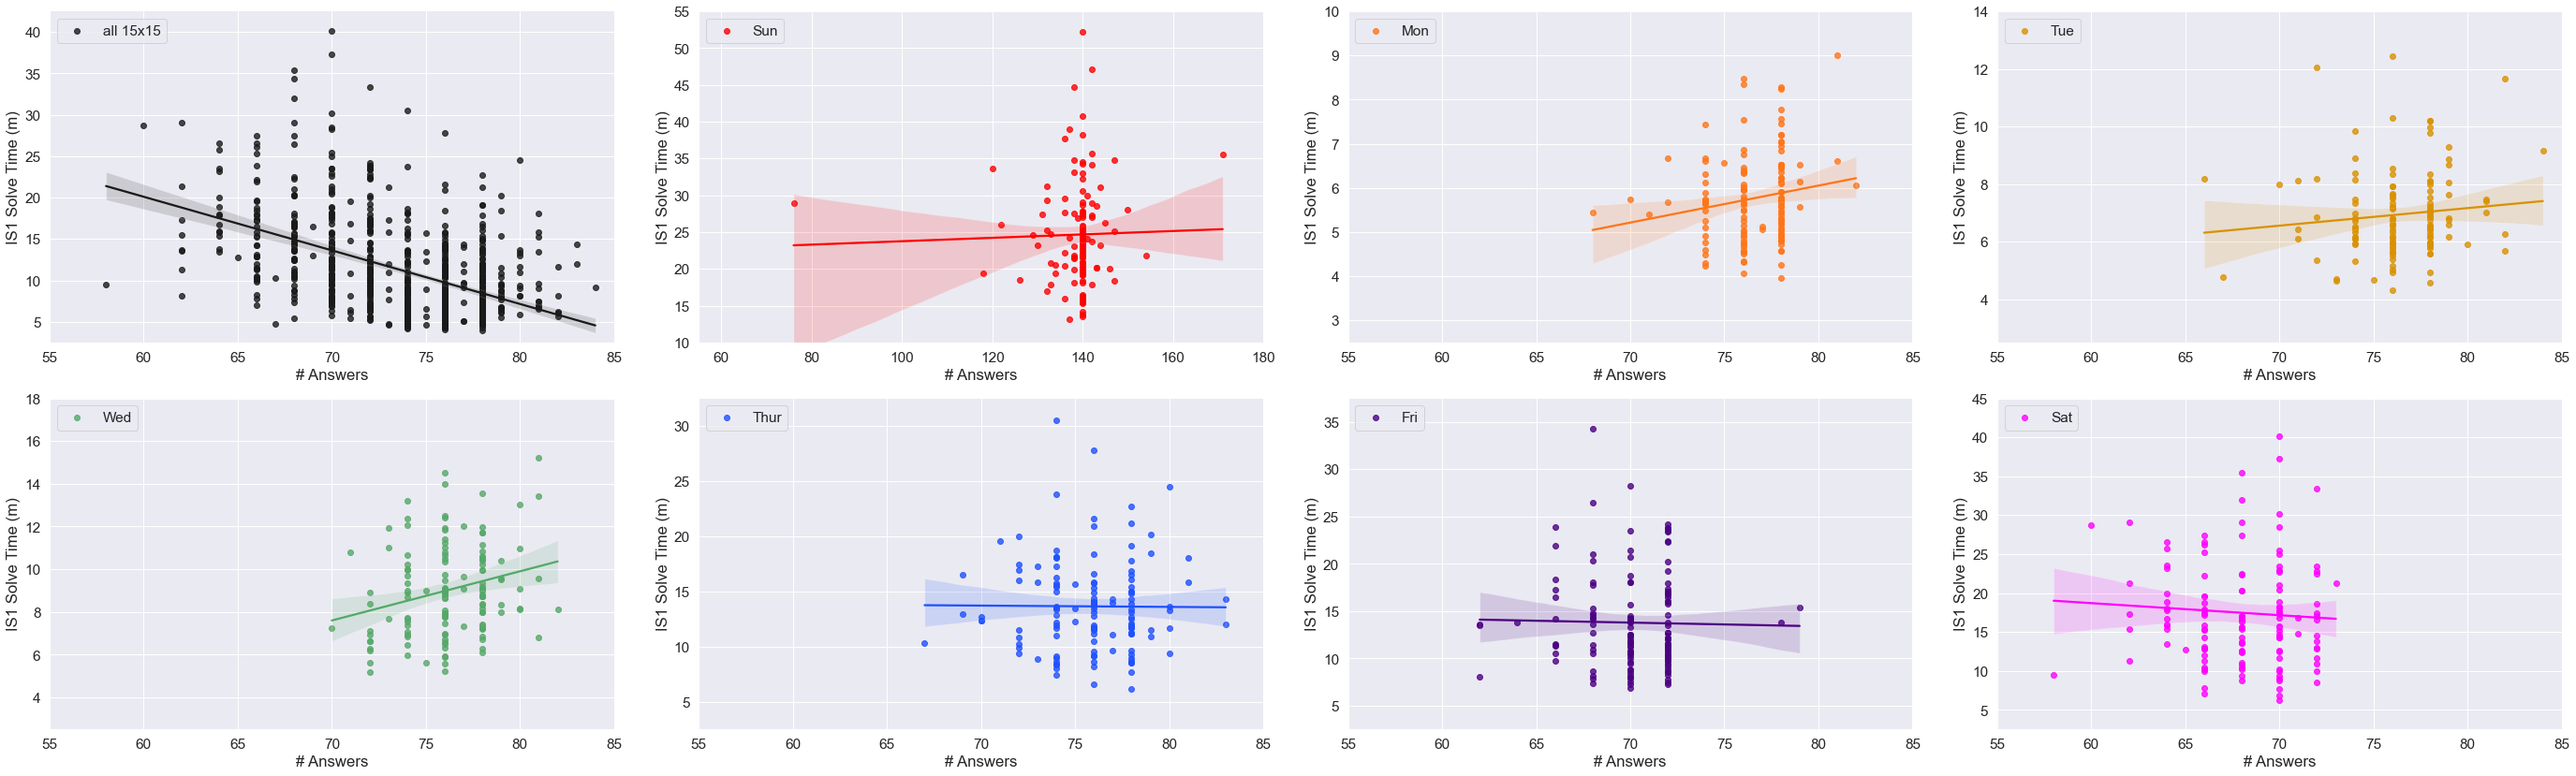

In [103]:
# Number of Answers vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Words", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Answers",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((55,85))
p.axes[1].set_xlim((55,180))
p.axes[2].set_xlim((55,85))
p.axes[3].set_xlim((55,85))
p.axes[4].set_xlim((55,85))
p.axes[5].set_xlim((55,85))
p.axes[6].set_xlim((55,85))
p.axes[7].set_xlim((55,85))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [104]:
# Calculate IS1 Pearson R for 15x15 grids for this feature
IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")] #only need to filter down this one time, and can apply to correlations for all subsequent features analysed

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Words']))

-0.47589653233620743


In [105]:
# Calculate GMS Pearson R for 15x15 grids for this feature

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Words']))

-0.6160566390061307


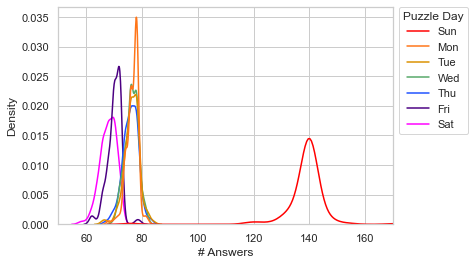

In [106]:
# Density plot of number of answers in puzzles solved by IS1
IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Words", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(50, 170)
ax.set_xlabel("# Answers")
plt.show()

In [107]:
IS1_df4["Words"].agg(['min', 'max'])

min     58
max    171
Name: Words, dtype: int64

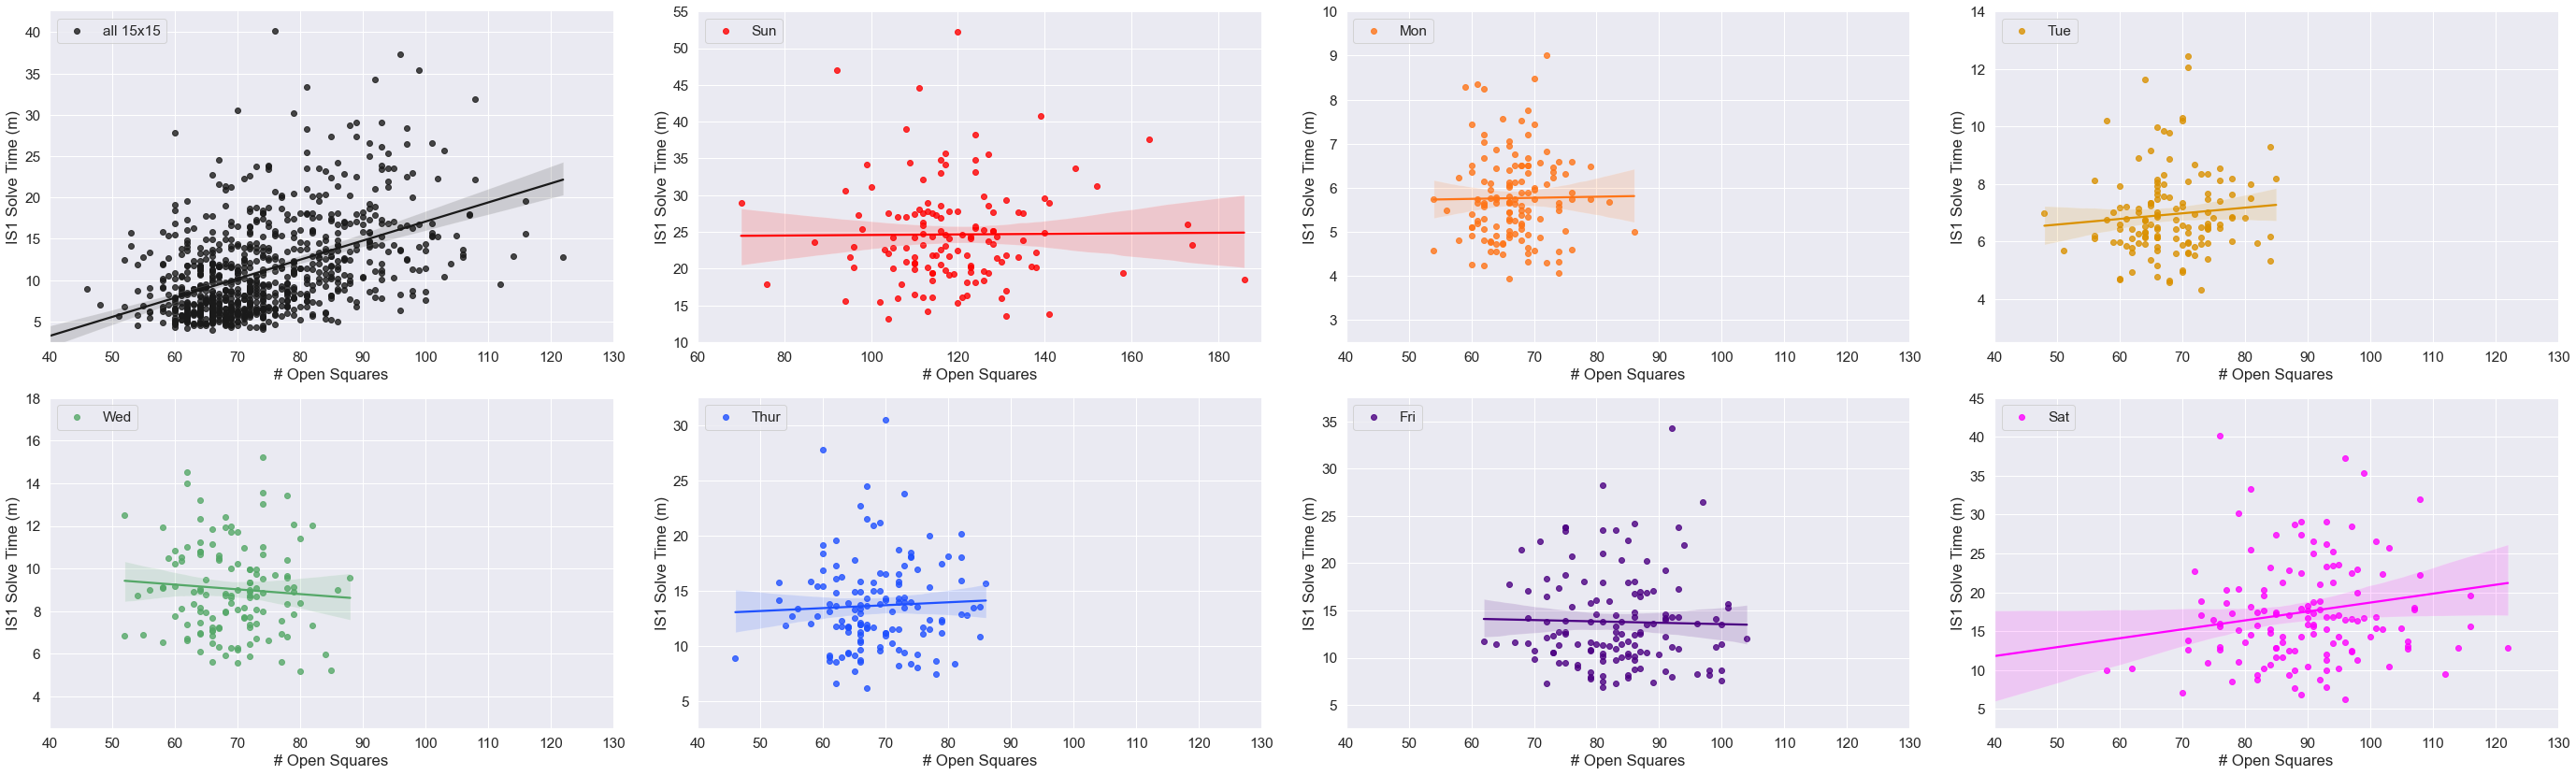

In [108]:
# Open Squares vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Open_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Open Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((40,130))
p.axes[1].set_xlim((60,190))
p.axes[2].set_xlim((40,130))
p.axes[3].set_xlim((40,130))
p.axes[4].set_xlim((40,130))
p.axes[5].set_xlim((40,130))
p.axes[6].set_xlim((40,130))
p.axes[7].set_xlim((40,130))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [109]:
# Calculate IS1 Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Open_Squares']))

0.47094221086349536


In [110]:
# Calculate GMS Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Open_Squares']))

0.6040661444724964


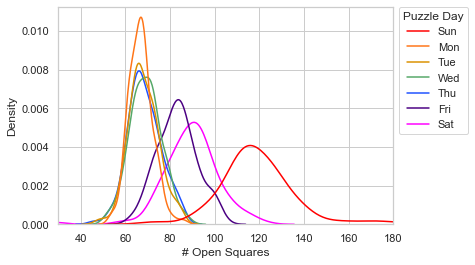

In [111]:
# Density plot of number of open squares in puzzles solved by IS1

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Open_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(30, 180)
ax.set_xlabel("# Open Squares")
plt.show()

In [112]:
IS1_df4["Open_Squares"].agg(['min', 'max'])

min     29
max    186
Name: Open_Squares, dtype: int64

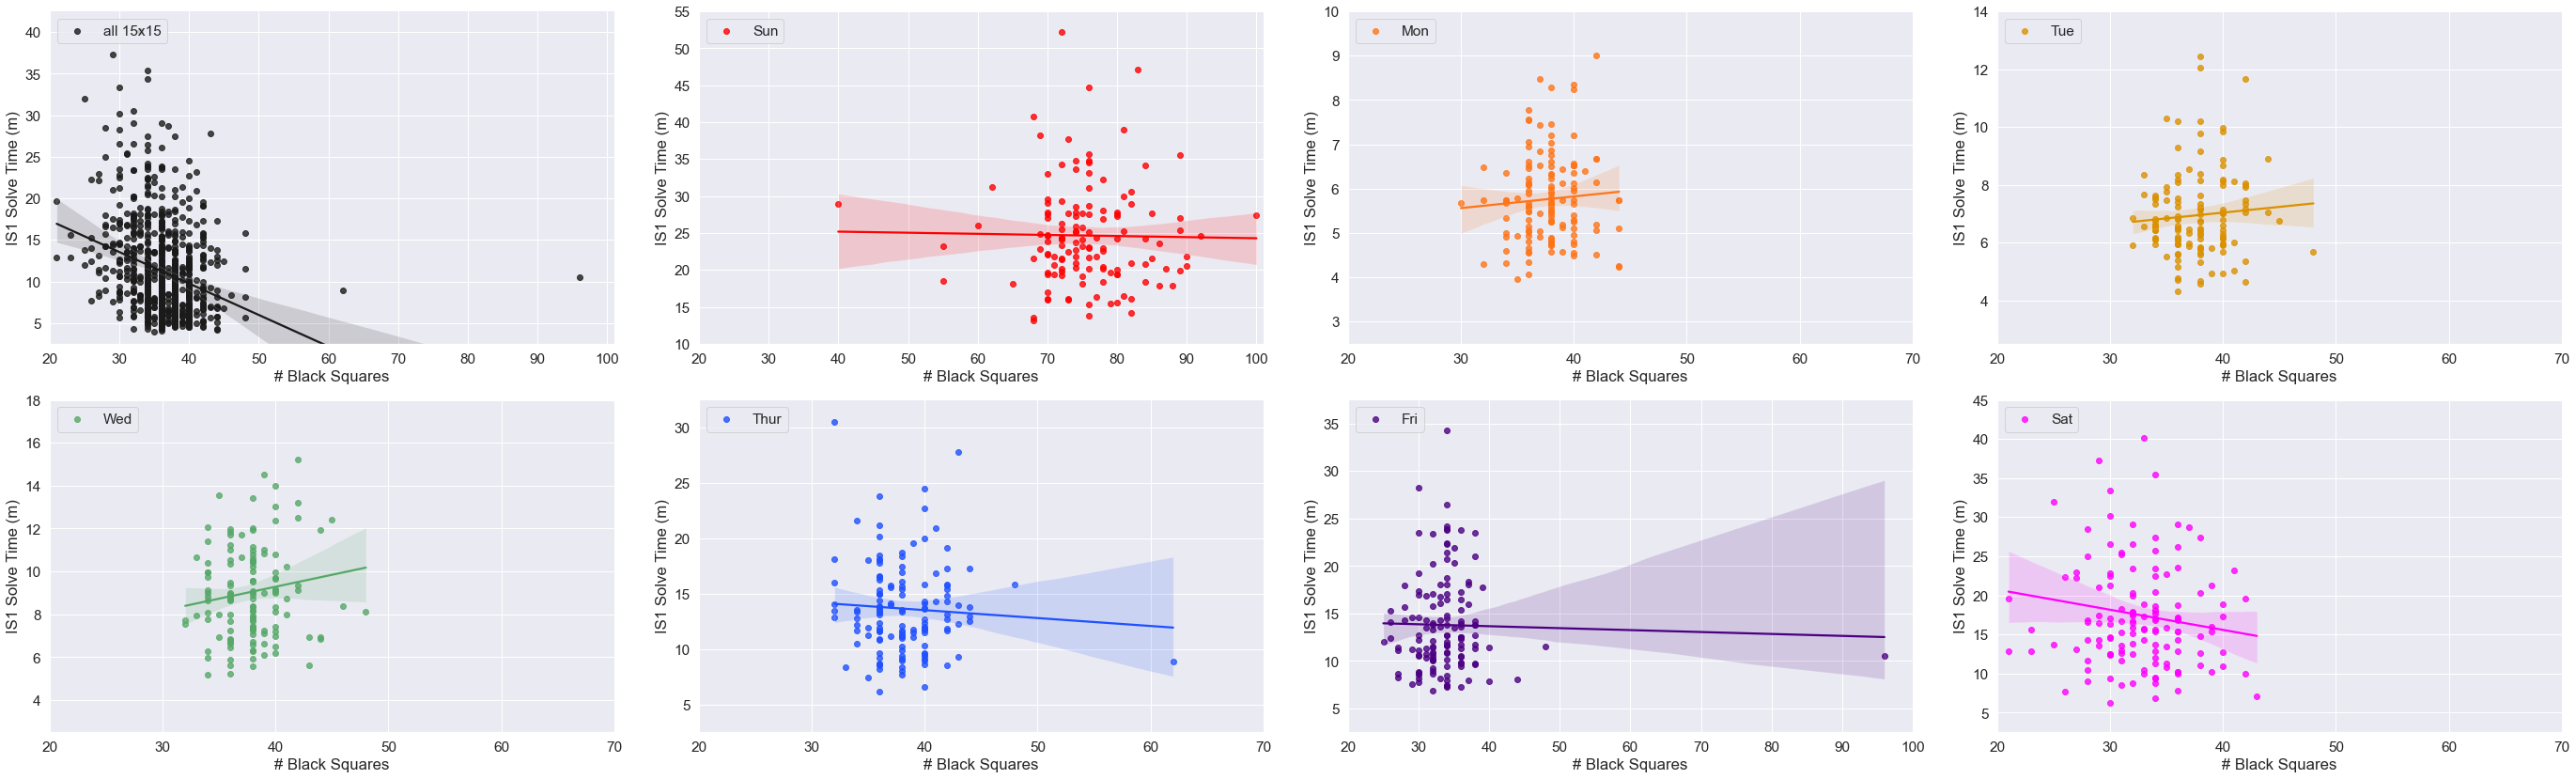

In [113]:
# Black Squares (blocks) vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Blocks", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Black Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((20,101))
p.axes[1].set_xlim((20,101))
p.axes[2].set_xlim((20,70))
p.axes[3].set_xlim((20,70))
p.axes[4].set_xlim((20,70))
p.axes[5].set_xlim((20,70))
p.axes[6].set_xlim((20,100))
p.axes[7].set_xlim((20,70))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [114]:
# Calculate Pearson R for IS1 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Blocks']))

-0.29232993963597514


In [115]:
# Calculate Pearson R for GMS 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Blocks']))

-0.3828686752114451


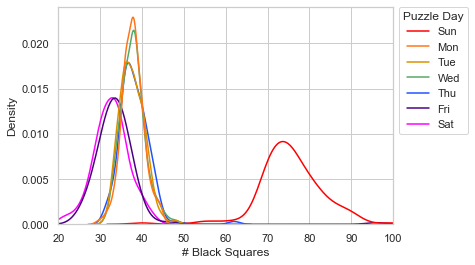

In [116]:
# Density plot of number of black squares (blocks) in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Blocks", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(20, 100)
ax.set_xlabel("# Black Squares")
plt.show()

In [117]:
IS1_df4["Blocks"].agg(['min', 'max'])

min     21
max    100
Name: Blocks, dtype: int64

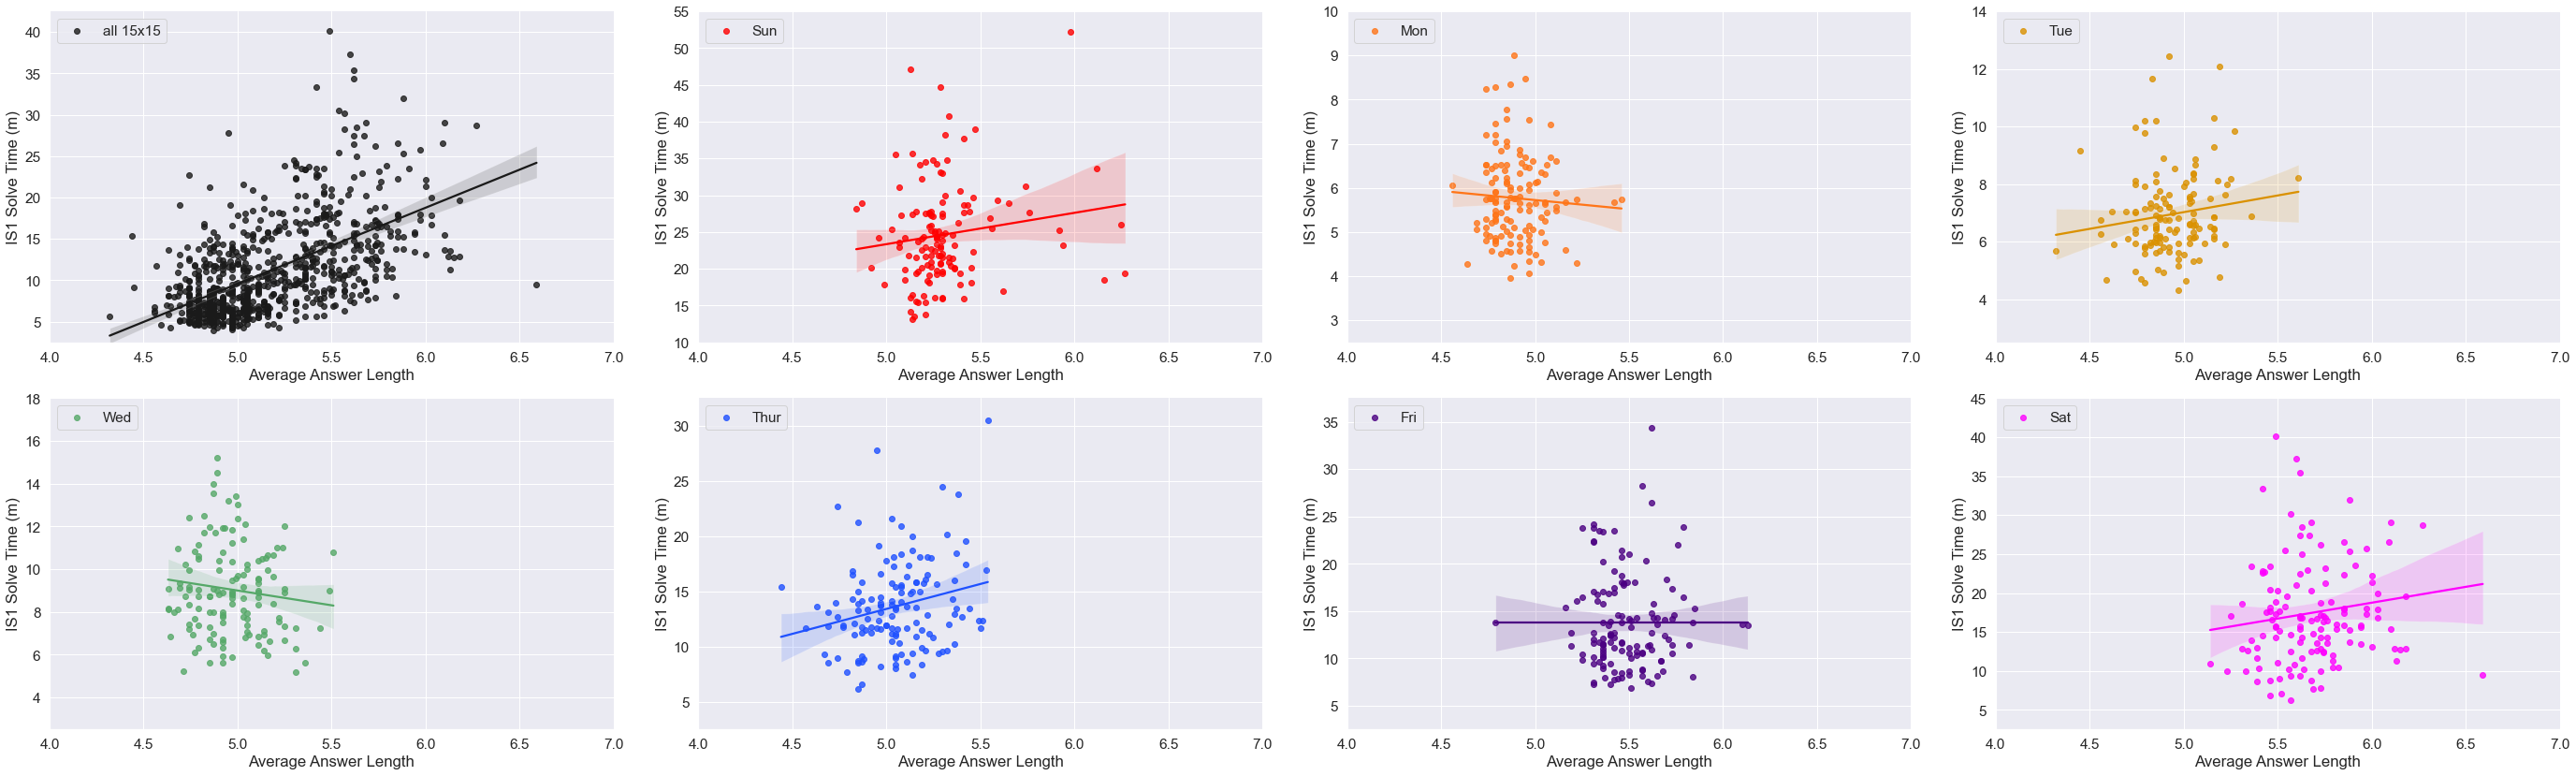

In [118]:
# Average Answer Length vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="AWL", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Average Answer Length",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((4,7))
p.axes[1].set_xlim((4,7))
p.axes[2].set_xlim((4,7))
p.axes[3].set_xlim((4,7))
p.axes[4].set_xlim((4,7))
p.axes[5].set_xlim((4,7))
p.axes[6].set_xlim((4,7))
p.axes[7].set_xlim((4,7))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [119]:
# Calculate Pearson R for IS1 for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['AWL']))

0.5620390234676625


In [120]:
# Calculate Pearson R for GMS for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['AWL']))

0.7139108748382355


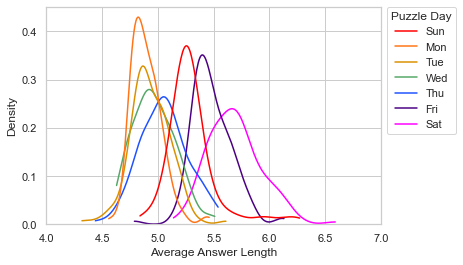

In [121]:
# Density plot of average answer length in puzzles solved by IS1

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "AWL", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(3,7))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(4, 7)
ax.set_xlabel("Average Answer Length")
plt.show()

In [122]:
IS1_df4["AWL"].agg(['min', 'max'])

min    4.32
max    6.59
Name: AWL, dtype: float64

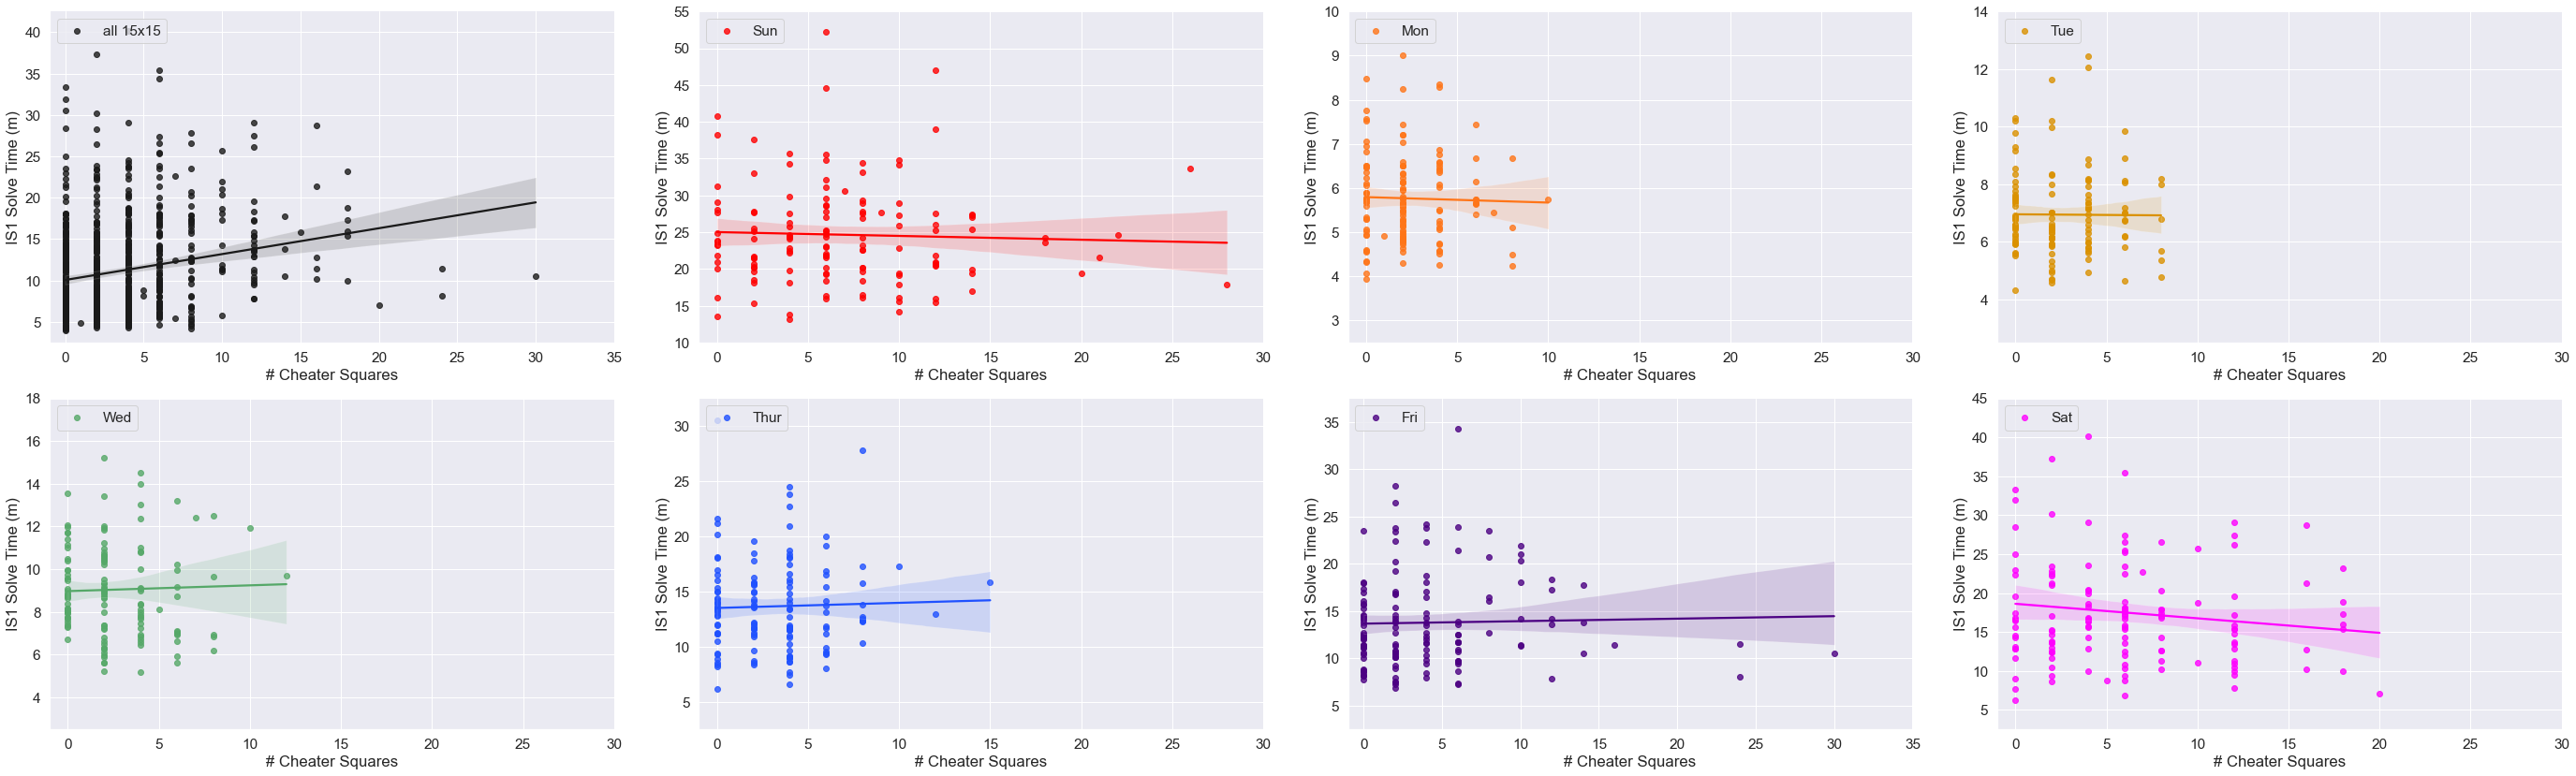

In [123]:
# Cheater Squares vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Cheater_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Cheater Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,35))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,30))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,35))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [124]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Cheater_Squares']))

0.19969671239941125


In [125]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Cheater_Squares']))

0.2361886408876766


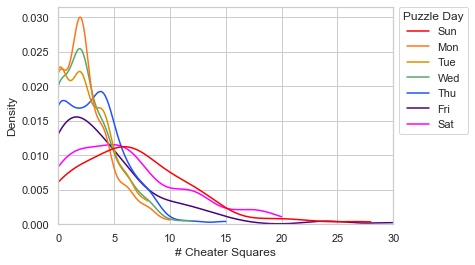

In [126]:
# Density plot of number of cheater squares in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Cheater_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,30))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 30)
ax.set_xlabel("# Cheater Squares")
plt.show()

In [127]:
IS1_df4["Cheater_Squares"].agg(['min', 'max'])

min     0
max    30
Name: Cheater_Squares, dtype: int64

In [ ]:
# Fill-in-the-blank clues vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="FITB", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Fill-in-the-Blank",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,45))
p.axes[1].set_xlim((-1,20))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,45))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['FITB']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['FITB']))

In [ ]:
# Density plot of number of fill-in-the-blank clues in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "FITB", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,45))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Fill-in-the-Blank")
plt.show()

In [ ]:
IS1_df4["FITB"].agg(['min', 'max'])

In [ ]:
# Scrabble Average vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Scrabble_Avg", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Average",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((1,2.2))
p.axes[1].set_xlim((1,2.2))
p.axes[2].set_xlim((1,2.2))
p.axes[3].set_xlim((1,2.2))
p.axes[4].set_xlim((1,2.2))
p.axes[5].set_xlim((1,2.2))
p.axes[6].set_xlim((1,2.2))
p.axes[7].set_xlim((1,2.2))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Scrabble_Avg']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Scrabble_Avg']))

In [ ]:
# Density plot of Scrabble Average in puzzles solved by IS1

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Scrabble_Avg", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(1.2, 2.2)
ax.set_xlabel("Scrabble Average")
plt.show()

In [ ]:
IS1_df4["Scrabble_Avg"].agg(['min', 'max'])

In [ ]:
# Scrabble Illegal # vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Scrabble_Illegal", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Scrabble Illegal",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,50))
p.axes[1].set_xlim((20,80))
p.axes[2].set_xlim((10,50))
p.axes[3].set_xlim((10,50))
p.axes[4].set_xlim((10,50))
p.axes[5].set_xlim((10,50))
p.axes[6].set_xlim((10,50))
p.axes[7].set_xlim((10,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for IS1 for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Scrabble_Illegal']))

In [ ]:
# Calculate Pearson R for GMS for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Scrabble_Illegal']))

In [ ]:
# Density plot of Scrabble Illegal # in puzzles solved by IS1

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Scrabble_Illegal", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 80)
ax.set_xlabel("# Scrabble Illegal")
plt.show()

In [ ]:
IS1_df4["Scrabble_Illegal"].agg(['min', 'max'])

In [ ]:
# Unique Answers # # vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Unique_Answers", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Unique Answers",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,17.5))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,17.5))
p.axes[3].set_xlim((-1,17.5))
p.axes[4].set_xlim((-1,17.5))
p.axes[5].set_xlim((-1,17.5))
p.axes[6].set_xlim((-1,17.5))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Unique_Answers']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Unique_Answers']))

In [ ]:
# Density plot of Unique Answers # in puzzles solved by IS1

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Unique_Answers", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,25))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Unique Answers")
plt.show()

In [ ]:
IS1_df4["Unique_Answers"].agg(['min', 'max'])

In [ ]:
# Freshness Factor vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Freshness_Factor", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Freshness Factor",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,90))
p.axes[1].set_xlim((10,90))
p.axes[2].set_xlim((10,90))
p.axes[3].set_xlim((10,90))
p.axes[4].set_xlim((10,90))
p.axes[5].set_xlim((10,90))
p.axes[6].set_xlim((10,90))
p.axes[7].set_xlim((10,90))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Freshness_Factor']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Freshness_Factor']))

In [ ]:
# Density plot of Freshness Factor in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Freshness_Factor", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 90)
ax.set_xlabel("Freshness Factor")
plt.show()

In [ ]:
IS1_df4["Freshness_Factor"].agg(['min', 'max'])

In [ ]:
# Wordplay vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Wordplay", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Wordplay",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,20))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,20))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Wordplay']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Wordplay']))

In [ ]:
# Density plot of Wordplay in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Wordplay", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 25)
ax.set_xlabel("# Wordplay")
plt.show()

In [ ]:
IS1_df4["Wordplay"].agg(['min', 'max'])

In [ ]:
# IS1 Recent Past Performance (Time-Decay Weighted Immediately Previous 10 Puzzles Prior to a given puzzle) vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="IS_pds_l10_dw", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "IS1 Adjusted Recent Performance (m)",
    ylabel="IS1 Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((2.5,42.5))
p.axes[1].set_xlim((10,55))
p.axes[2].set_xlim((2.5,10))
p.axes[3].set_xlim((2.5,14))
p.axes[4].set_xlim((2.5,18))
p.axes[5].set_xlim((2.5,32.5))
p.axes[6].set_xlim((2.5,37.5))
p.axes[7].set_xlim((2.5,45))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,55))
p.axes[2].set_ylim((2.5,10))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,18))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,37.5))
p.axes[7].set_ylim((2.5,45))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
#GMS Recent Past Performance (Time-Decay Weighted Immediately Previous 10 Puzzles Prior to a given puzzle) vs GMS Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="GMS_pds_l10_dw", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "GMS Adjusted Recent Performance (m)",
    ylabel="GMS Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((2.5,42.5))
p.axes[1].set_xlim((10,60))
p.axes[2].set_xlim((2.5,14))
p.axes[3].set_xlim((2.5,14))
p.axes[4].set_xlim((2.5,20))
p.axes[5].set_xlim((2.5,32.5))
p.axes[6].set_xlim((2.5,35))
p.axes[7].set_xlim((2.5,42.5))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['IS_pds_l10_dw']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['IS_pds_l10_dw']))

IS1_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['IS_pds_l10_dw']))

IS1_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['IS_pds_l10_dw']))

IS1_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['IS_pds_l10_dw']))

IS1_Thu = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['IS_pds_l10_dw']))

IS1_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['IS_pds_l10_dw']))

IS1_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['IS_pds_l10_dw']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

# print(IS1_15x15['GMST(m)'].corr(IS1_15x15['GMS_pds_l10_dw']))

# # Calculate Pearson R for each puzzle day for this feature
# IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
# print(IS1_Sun['GMST(m)'].corr(IS1_Sun['GMS_pds_l10_dw']))

# IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
# print(IS1_Mon['GMST(m)'].corr(IS1_Mon['GMS_pds_l10_dw']))

# IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
# print(IS1_Tue['GMST(m)'].corr(IS1_Tue['GMS_pds_l10_dw']))

# IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
# print(IS1_Wed['GMST(m)'].corr(IS1_Wed['GMS_pds_l10_dw']))

# IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
# print(IS1_Thu['GMST(m)'].corr(IS1_Thu['GMS_pds_l10_dw']))

# IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
# print(IS1_Fri['GMST(m)'].corr(IS1_Fri['GMS_pds_l10_dw']))

# IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
# print(IS1_Sat['GMST(m)'].corr(IS1_Sat['GMS_pds_l10_dw']))

In [ ]:
IS1_Thu.to_csv('../data/IS1_Thu.csv', index=False)

In [ ]:
IS1_15x15.info()

### Data Supplement

In [ ]:
# Rebus vs IS1 Raw Solve Times
#Supp. Fig. 2

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Rebus_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Rebus",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,30))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,30))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,30))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for 15x15 grids for IS1 for this feature
#IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Rebus_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['Rebus_Count']))

IS1_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['Rebus_Count']))

IS1_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['Rebus_Count']))

IS1_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['Rebus_Count']))

IS1_Thu = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['Rebus_Count']))

IS1_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['Rebus_Count']))

IS1_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['Rebus_Count']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMST for this feature
#IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Rebus_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
print(IS1_Sun['GMST(m)'].corr(IS1_Sun['Rebus_Count']))

IS1_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
print(IS1_Mon['GMST(m)'].corr(IS1_Mon['Rebus_Count']))

IS1_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
print(IS1_Tue['GMST(m)'].corr(IS1_Tue['Rebus_Count']))

IS1_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
print(IS1_Wed['GMST(m)'].corr(IS1_Wed['Rebus_Count']))

IS1_Thu = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
print(IS1_Thu['GMST(m)'].corr(IS1_Thu['Rebus_Count']))

IS1_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
print(IS1_Fri['GMST(m)'].corr(IS1_Fri['Rebus_Count']))

IS1_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
print(IS1_Sat['GMST(m)'].corr(IS1_Sat['Rebus_Count']))

In [ ]:
# Density plot of Rebus Count in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df4, x = "Rebus_Count", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 1)
ax.set_xlabel("# Rebus")
plt.show()

In [ ]:
# Circles vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Circle_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Circles",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for IS1 for 15x15 grids for this feature
#IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Circle_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['Circle_Count']))

IS1_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['Circle_Count']))

IS1_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['Circle_Count']))

IS1_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['Circle_Count']))

IS1_Thu = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['Circle_Count']))

IS1_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['Circle_Count']))

IS1_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['Circle_Count']))

In [ ]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Circle_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
print(IS1_Sun['GMST(m)'].corr(IS1_Sun['Circle_Count']))

IS1_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
print(IS1_Mon['GMST(m)'].corr(IS1_Mon['Circle_Count']))

IS1_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
print(IS1_Tue['GMST(m)'].corr(IS1_Tue['Circle_Count']))

IS1_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
print(IS1_Wed['GMST(m)'].corr(IS1_Wed['Circle_Count']))

IS1_Thu = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
print(IS1_Thu['GMST(m)'].corr(IS1_Thu['Circle_Count']))

IS1_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
print(IS1_Fri['GMST(m)'].corr(IS1_Fri['Circle_Count']))

IS1_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
print(IS1_Sat['GMST(m)'].corr(IS1_Sat['Circle_Count']))

In [ ]:
# Shaded Squares vs IS1 Raw Solve Times

IS1_df4a = IS1_df4a.sort_values(by=['DOW_num'], ascending = True)

IS1_df4a['plot_seq_map'] = IS1_df4a['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4a, x="Shade_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Shaded Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Calculate Pearson R for IS1 for 15x15 grids for this feature
#IS1_15x15 = IS1_df4.loc[IS1_df4["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Shade_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df4.loc[IS1_df4["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['Shade_Count']))

IS1_Mon = IS1_df4.loc[IS1_df4["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['Shade_Count']))

IS1_Tue = IS1_df4.loc[IS1_df4["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['Shade_Count']))

IS1_Wed = IS1_df4.loc[IS1_df4["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['Shade_Count']))

IS1_Thu = IS1_df4.loc[IS1_df4["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['Shade_Count']))

IS1_Fri = IS1_df4.loc[IS1_df4["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['Shade_Count']))

IS1_Sat = IS1_df4.loc[IS1_df4["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['Shade_Count']))

In [ ]:
# Calculate Pearson R for GMS for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['GMST(m)'].corr(IS1_15x15['Shade_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
print(IS1_Sun['GMST(m)'].corr(IS1_Sun['Shade_Count']))

IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
print(IS1_Mon['GMST(m)'].corr(IS1_Mon['Shade_Count']))

IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
print(IS1_Tue['GMST(m)'].corr(IS1_Tue['Shade_Count']))

IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
print(IS1_Wed['GMST(m)'].corr(IS1_Wed['Shade_Count']))

IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
print(IS1_Thu['GMST(m)'].corr(IS1_Thu['Shade_Count']))

IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
print(IS1_Fri['GMST(m)'].corr(IS1_Fri['Shade_Count']))

IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
print(IS1_Sat['GMST(m)'].corr(IS1_Sat['Shade_Count']))